In [1]:
# Import modules
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy as np

In [2]:
# Directories and files
DATA_DIR = "../../data/kosdaq/combined/"

# File Names
TEST_NUMBER = "test1"
FILE_PEARSON = "../peak_price_pearson_{}.csv".format(TEST_NUMBER)
FILE_NCC = "../peak_price_ncc_{}.csv".format(TEST_NUMBER)
FILE_PCT = "../peak_price_pct_{}.csv".format(TEST_NUMBER)

In [3]:
# Load Data File List
file_list = os.listdir(DATA_DIR)
noisy = ['001000']

file_list = [f for f in file_list if f[:-4] not in noisy]
codes_list = [f[:-4] for f in file_list if f[:-4] not in noisy]

In [4]:
codes_list[:5]

['000250', '000440', '001540', '001810', '001840']

In [5]:
def ccf(x, y, lag_max = 100):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [6]:
ncc_pct_list = []
lag_pct_list = []
company_values = {}
lag = 7
scale_columns = ['volume', 'price', 'ratio']

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath, index_col=0)
    df[scale_columns] -= df[scale_columns].min()
    df[scale_columns] /= df[scale_columns].max()
    df = df.dropna()
    
    peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
    top_peaks = df.iloc[peaks,:]
    top_peaks = top_peaks.nlargest(20, 'ratio')
    print(top_peaks)
    
    
    top_timeframes = {}
    # print(top_ten)
    
    # Create timeframe for each peak
    for idx, row in top_peaks.iterrows():
        # print(row)
        start = idx-lag 
        end = idx+lag
        if start < 0 or end > len(df.index):
            continue
        # print("Start: ", start, "End: ", end)
        timeframe = df[start:end]
        top_timeframes[row['period']] = timeframe
        
    # print(top_timeframes)
        
    # Calculate cross correlation
    top_ncc = {}
    for peak, timeframe in top_timeframes.items():
        prices = timeframe['volume'].values
        ratio = timeframe['ratio'].values    
        ncc = ccf(prices,ratio,lag_max=lag)
        max_idx = np.argmax(abs(ncc))
        max_ncc = ncc[max_idx]
        max_lag = max_idx - lag 
        top_ncc[peak] = {
            "ncc": list(ncc),
            "max": [max_ncc, max_lag]
        }
        ncc_pct_list.append(max_ncc)
        lag_pct_list.append(max_lag)
        
    company_values[file[:-4]] = top_ncc
    # print(company_values)
    # print(file, max_ncc, max_lag)
    

          period     price    volume     ratio
781   2018-02-20  0.663419  0.893551  1.000000
826   2018-04-06  0.929141  0.389825  0.503114
741   2018-01-11  0.395483  0.572906  0.429414
801   2018-03-12  0.806244  0.221907  0.410757
760   2018-01-30  0.714349  0.112490  0.407267
753   2018-01-23  0.544951  0.202523  0.341678
768   2018-02-07  0.593667  0.147714  0.337786
833   2018-04-13  0.944641  0.130201  0.317422
808   2018-03-19  0.736492  0.108370  0.290905
970   2018-08-28  0.880425  0.195643  0.275512
991   2018-09-18  0.949070  0.174091  0.257081
791   2018-03-02  0.641275  0.057061  0.255123
1147  2019-02-21  0.957927  0.114976  0.251984
816   2018-03-27  0.720992  0.054535  0.229108
348   2016-12-14  0.096546  1.000000  0.223609
1137  2019-02-11  0.902569  0.041963  0.220495
1126  2019-01-31  0.837245  0.077082  0.212711
843   2018-04-23  0.901461  0.032801  0.208518
1181  2019-03-27  0.889283  0.105933  0.205354
860   2018-05-10  0.832817  0.078299  0.200733
          per

          period     price    volume     ratio
759   2018-01-29  0.576577  0.957676  1.000000
864   2018-05-14  1.000000  0.778039  0.896226
852   2018-05-02  0.716216  0.742186  0.736635
878   2018-05-28  0.761261  0.704570  0.616352
885   2018-06-04  0.729730  0.263095  0.505503
839   2018-04-19  0.423423  0.203014  0.451258
900   2018-06-19  0.454955  0.381478  0.431604
270   2016-09-27  0.360360  0.167766  0.416667
871   2018-05-21  0.774775  0.127082  0.393082
670   2017-11-01  0.468468  0.097585  0.385220
892   2018-06-11  0.707207  0.056372  0.366352
222   2016-08-10  0.297297  0.014574  0.345126
1133  2019-02-07  0.319820  0.142985  0.326258
767   2018-02-06  0.468468  0.222968  0.316038
920   2018-07-09  0.351351  0.323053  0.307390
685   2017-11-16  0.463964  0.060511  0.300314
396   2017-01-31  0.261261  0.053351  0.296384
33    2016-02-03  0.261261  0.009424  0.292453
1200  2019-04-15  0.238739  0.024658  0.281447
1208  2019-04-23  0.216216  0.017359  0.279088
          per

          period     price    volume     ratio
969   2018-08-27  0.282655  0.504720  1.000000
420   2017-02-24  0.693790  0.485501  0.900889
229   2016-08-17  0.698073  1.000000  0.856459
1333  2019-08-26  0.074946  0.543211  0.492823
795   2018-03-06  0.552463  0.024983  0.419686
466   2017-04-11  0.396146  0.019586  0.398496
441   2017-03-17  0.394004  0.115692  0.356118
684   2017-11-15  0.650964  0.088455  0.343131
1211  2019-04-26  0.280514  0.027562  0.339029
320   2016-11-16  0.627409  0.057160  0.331511
948   2018-08-06  0.301927  0.002697  0.300752
452   2017-03-28  0.471092  0.051531  0.289815
473   2017-04-18  0.346895  0.015821  0.287765
266   2016-09-23  0.901499  0.031363  0.285714
480   2017-04-25  0.353319  0.016352  0.280930
313   2016-11-09  0.505353  0.016511  0.277512
811   2018-03-22  0.520343  0.015634  0.277512
977   2018-09-04  0.252677  0.048052  0.276828
916   2018-07-05  0.169165  0.054790  0.276145
137   2016-05-17  0.441113  0.110869  0.272727
          per

         period     price    volume     ratio
770  2018-02-09  1.000000  1.000000  1.000000
181  2016-06-30  0.856691  0.213104  0.521347
825  2018-04-05  0.850369  0.499090  0.476029
119  2016-04-29  0.656481  0.570593  0.416565
781  2018-02-20  0.879874  0.151629  0.321577
143  2016-05-23  0.972603  0.196557  0.279716
460  2017-04-05  0.361433  0.301165  0.242847
837  2018-04-17  0.922023  0.136539  0.232030
130  2016-05-10  0.593256  0.208058  0.176727
521  2017-06-05  0.408851  0.149807  0.164373
983  2018-09-10  0.387777  0.040463  0.154836
684  2017-11-15  0.370917  0.078594  0.139218
159  2016-06-08  0.721812  0.043253  0.136081
804  2018-03-15  0.793467  0.023090  0.135249
811  2018-03-22  0.780822  0.044437  0.120783
350  2016-12-16  0.479452  0.114790  0.111886
795  2018-03-06  0.711275  0.013636  0.109838
188  2016-07-07  0.755532  0.039193  0.109390
150  2016-05-30  0.633298  0.033327  0.109262
763  2018-02-02  0.494204  0.028697  0.099277
          period     price    volu

         period     price    volume     ratio
319  2019-07-04  0.134835  0.000000  1.000000
354  2019-08-08  0.134835  0.000000  0.903438
214  2019-03-21  0.241331  0.000916  0.601317
394  2019-09-17  0.134835  0.000000  0.494513
382  2019-09-05  0.134835  0.000000  0.422092
339  2019-07-24  0.134835  0.000000  0.420629
284  2019-05-30  0.146277  0.001283  0.336503
362  2019-08-16  0.134835  0.000000  0.326262
165  2019-01-31  0.228569  0.000249  0.318215
233  2019-04-09  0.210086  0.000801  0.312363
225  2019-04-01  0.225929  0.000188  0.308705
183  2019-02-18  0.245291  0.000553  0.294806
172  2019-02-07  0.228129  0.000468  0.256767
241  2019-04-17  0.208326  0.000208  0.253109
262  2019-05-08  0.186323  0.000755  0.252377
193  2019-02-28  0.240011  0.000410  0.250914
372  2019-08-26  0.134835  0.000000  0.249451
269  2019-05-15  0.181042  0.000157  0.236284
304  2019-06-19  0.150238  0.000093  0.227505
204  2019-03-11  0.221088  0.000217  0.220922
          period     price    volu

C:\Users\bon12\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


          period     price    volume     ratio
991   2018-09-18  0.759458  0.875053  1.000000
1320  2019-08-13  0.435347  0.273165  0.758133
1106  2019-01-11  0.768492  0.489493  0.611397
1118  2019-01-23  0.937888  0.553204  0.581308
846   2018-04-26  0.435347  1.000000  0.491117
1000  2018-09-27  0.689441  0.422814  0.415923
984   2018-09-11  0.577640  0.537890  0.396755
888   2018-06-07  0.574252  0.689207  0.386834
864   2018-05-14  0.516657  0.191230  0.291548
854   2018-05-04  0.453416  0.307347  0.285146
880   2018-05-30  0.481649  0.156020  0.250077
1007  2018-10-04  0.704122  0.159681  0.219872
1020  2018-10-17  0.569735  0.262653  0.199435
1127  2019-02-01  0.943535  0.092182  0.190437
1154  2019-02-28  0.621683  0.068449  0.182035
1068  2018-12-04  0.564088  0.143468  0.180670
1137  2019-02-11  0.926595  0.056731  0.169634
1354  2019-09-16  0.473744  0.163389  0.152349
895   2018-06-14  0.369848  0.064871  0.150984
1145  2019-02-19  0.870130  0.039661  0.143505
          per

          period     price    volume     ratio
1181  2019-03-27  0.547377  1.000000  1.000000
865   2018-05-15  0.940778  0.908977  0.890394
544   2017-06-28  0.653130  0.848328  0.663986
1194  2019-04-09  0.547377  0.492835  0.613627
899   2018-06-18  0.902707  0.712977  0.548667
1146  2019-02-20  0.475465  0.165638  0.377486
783   2018-02-22  0.716582  0.200075  0.375159
873   2018-05-23  0.890017  0.185341  0.361617
255   2016-09-12  0.354484  0.796721  0.350614
570   2017-07-24  0.877327  0.134675  0.339822
987   2018-09-14  0.606599  0.074839  0.330089
560   2017-07-14  0.763113  0.137754  0.309987
1208  2019-04-23  0.479695  0.038663  0.275286
956   2018-08-14  0.543147  0.131158  0.253491
1139  2019-02-13  0.433164  0.066708  0.250106
500   2017-05-15  0.283418  0.415659  0.243123
591   2017-08-14  0.555838  0.051468  0.242065
243   2016-08-31  0.262267  0.490213  0.240796
1109  2019-01-14  0.335025  0.068051  0.236775
908   2018-06-27  0.716582  0.104029  0.231697
          per

          period     price    volume     ratio
313   2016-11-09  0.761905  0.714122  1.000000
42    2016-02-12  0.634354  1.000000  0.970616
5     2016-01-06  0.527211  0.819646  0.791133
465   2017-04-10  0.773810  0.919942  0.749217
881   2018-05-31  1.000000  0.316632  0.620384
587   2017-08-10  0.571429  0.716367  0.596649
62    2016-03-03  0.600340  0.414002  0.511203
252   2016-09-09  0.506803  0.446360  0.507263
612   2017-09-04  0.534014  0.234856  0.501709
850   2018-04-30  0.537415  0.238102  0.470711
1154  2019-02-28  0.345238  0.027413  0.411516
550   2017-07-04  0.486395  0.239319  0.344916
54    2016-02-24  0.651361  0.345994  0.336656
137   2016-05-17  0.608844  0.293877  0.327447
189   2016-07-08  0.566327  0.501968  0.313159
69    2016-03-10  0.596939  0.087161  0.265926
866   2018-05-16  0.574830  0.158127  0.259233
479   2017-04-24  0.576531  0.233468  0.253869
858   2018-05-08  0.653061  0.068526  0.253299
472   2017-04-17  0.579932  0.072286  0.238014
          per

         period     price    volume     ratio
196  2016-07-15  0.821779  0.672413  1.000000
668  2017-10-30  0.408110  0.559700  0.937742
685  2017-11-16  0.550360  0.671552  0.913361
822  2018-04-02  0.610857  0.332716  0.731062
472  2017-04-17  0.386854  0.753188  0.713391
675  2017-11-06  0.457162  0.133165  0.571279
697  2017-11-28  0.555265  0.214157  0.570534
752  2018-01-22  0.516024  0.153145  0.473531
102  2016-04-12  0.771092  0.176133  0.432374
829  2018-04-09  0.589601  0.096940  0.423501
502  2017-05-17  0.486593  0.117874  0.409186
798  2018-03-09  0.486593  0.244930  0.395989
705  2017-12-06  0.499673  0.103565  0.388234
153  2016-06-02  0.735121  0.114416  0.385699
815  2018-03-26  0.537279  0.066871  0.369893
943  2018-08-01  0.354153  0.271122  0.351774
762  2018-02-01  0.511118  0.094100  0.336117
210  2016-07-29  0.740026  0.117024  0.323516
836  2018-04-16  0.560170  0.047259  0.320608
298  2016-10-25  0.476782  0.057562  0.306144
          period     price    volu

          period     price    volume     ratio
852   2018-05-02  0.621270  0.390326  1.000000
867   2018-05-17  0.793420  0.528641  0.946103
879   2018-05-29  0.973221  0.350011  0.925093
787   2018-02-26  0.372609  0.257669  0.714238
263   2016-09-20  0.369549  0.703015  0.658591
796   2018-03-07  0.348125  0.518268  0.594852
824   2018-04-04  0.418516  0.441263  0.497516
475   2017-04-20  0.342005  1.000000  0.495197
893   2018-06-12  0.690130  0.066650  0.471632
839   2018-04-19  0.517980  0.197069  0.424549
174   2016-06-23  0.123948  0.483785  0.413287
181   2016-06-30  0.174445  0.397848  0.370179
860   2018-05-10  0.560826  0.073868  0.352151
549   2017-07-03  0.259373  0.568090  0.339706
466   2017-04-11  0.213466  0.584580  0.326598
906   2018-06-25  0.590666  0.047893  0.308002
979   2018-09-06  0.500383  0.119321  0.304216
1104  2019-01-09  0.429992  0.110339  0.267354
958   2018-08-16  0.497322  0.053435  0.260398
817   2018-03-28  0.370314  0.118955  0.258506
          per

          period     price    volume     ratio
434   2017-03-10  0.749000  0.313653  1.000000
299   2016-10-26  0.989087  0.439764  0.673586
251   2016-09-08  0.872681  0.446554  0.653326
495   2017-05-10  0.220080  0.169011  0.561668
452   2017-03-28  0.698072  0.198865  0.466471
459   2017-04-04  0.393234  0.145139  0.412273
262   2016-09-19  1.000000  0.158088  0.396905
402   2017-02-06  0.836304  0.141381  0.368961
292   2016-10-19  0.661695  0.260449  0.364176
473   2017-04-18  0.479811  0.168164  0.353042
343   2016-12-09  0.858130  0.069356  0.324635
244   2016-09-01  0.539469  0.255737  0.306083
306   2016-11-02  0.854493  0.087822  0.295571
193   2016-07-12  0.414332  0.207017  0.293134
1243  2019-05-28  0.105129  1.000000  0.279224
1020  2018-10-17  0.048381  0.029654  0.277072
333   2016-11-29  0.789014  0.184420  0.275756
273   2016-09-30  0.850855  0.087075  0.265404
487   2017-05-02  0.285558  0.114951  0.261224
111   2016-04-21  0.152055  0.446634  0.253575
          per

          period     price    volume     ratio
398   2017-02-02  1.000000  0.777034  1.000000
327   2016-11-23  0.858491  0.776200  0.799608
299   2016-10-26  0.629717  0.760574  0.745091
111   2016-04-21  0.459906  0.609503  0.701741
83    2016-03-24  0.268868  0.803695  0.696025
354   2016-12-20  0.969340  0.627685  0.685862
189   2016-07-08  0.679245  0.745444  0.659186
167   2016-06-16  0.497642  0.884722  0.574181
347   2016-12-13  0.851415  0.477835  0.554862
1083  2018-12-19  0.478774  1.000000  0.504102
308   2016-11-04  0.733491  0.193714  0.483565
452   2017-03-28  0.502358  0.164516  0.468322
469   2017-04-14  0.384434  0.406466  0.465940
434   2017-03-10  0.617925  0.368071  0.455407
319   2016-11-15  0.865566  0.385331  0.453131
361   2016-12-27  0.875000  0.111543  0.375218
1028  2018-10-25  0.089623  0.833254  0.361827
391   2017-01-26  0.759434  0.047659  0.358440
410   2017-02-14  0.627358  0.178133  0.353252
339   2016-12-05  0.724057  0.091394  0.332081
          per

          period     price    volume     ratio
878   2018-05-28  1.000000  1.000000  1.000000
864   2018-05-14  0.801370  0.797636  0.803422
852   2018-05-02  0.680822  0.706523  0.686072
89    2016-03-30  0.130137  0.427639  0.626120
893   2018-06-12  0.717808  0.287416  0.570602
759   2018-01-29  0.395890  0.776783  0.563759
885   2018-06-04  0.791781  0.249337  0.531277
839   2018-04-19  0.500000  0.509677  0.487952
119   2016-04-29  0.269863  0.454398  0.483711
193   2016-07-12  0.184932  0.040381  0.473928
984   2018-09-11  0.567123  0.361860  0.459518
1127  2019-02-01  0.569863  0.342133  0.417735
101   2016-04-11  0.219178  0.292266  0.395614
871   2018-05-21  0.742466  0.140168  0.381976
140   2016-05-20  0.204110  0.315137  0.341783
991   2018-09-18  0.527397  0.186903  0.340867
901   2018-06-20  0.608219  0.101058  0.328675
922   2018-07-11  0.463014  0.202400  0.307663
913   2018-07-02  0.420548  0.225232  0.307084
1083  2018-12-19  0.387671  0.305640  0.305976
          per

1047  2018-11-13  0.105882  0.221717  0.047333
         period     price    volume     ratio
411  2017-02-15  1.000000  0.709589  1.000000
241  2016-08-29  0.678404  0.542296  0.972014
249  2016-09-06  0.884977  1.000000  0.717747
318  2016-11-14  0.683099  0.096821  0.344369
264  2016-09-21  0.732394  0.101733  0.260410
256  2016-09-13  0.570423  0.131526  0.259727
419  2017-02-23  0.809859  0.031814  0.200341
271  2016-09-28  0.690141  0.037450  0.179864
866  2018-05-16  0.326291  0.035817  0.168601
462  2017-04-07  0.838028  0.022434  0.154949
151  2016-05-31  0.307512  0.008549  0.151877
284  2016-10-11  0.509390  0.018889  0.150853
334  2016-11-30  0.556338  0.017224  0.138567
369  2017-01-04  0.652582  0.047586  0.136519
753  2018-01-23  0.410798  0.015993  0.136519
853  2018-05-03  0.225352  0.021644  0.134130
445  2017-03-21  0.765258  0.020561  0.131399
431  2017-03-07  0.732394  0.012642  0.129693
760  2018-01-30  0.481221  0.030141  0.126621
349  2016-12-15  0.624413  0.0446

          period     price    volume     ratio
1281  2019-07-05  0.231760  1.000000  1.000000
1294  2019-07-18  0.339056  0.404539  0.377948
854   2018-05-04  0.491416  0.129014  0.177109
665   2017-10-27  0.407725  0.230970  0.158732
369   2017-01-04  0.521459  0.120910  0.151208
1305  2019-07-29  0.259657  0.223536  0.148748
943   2018-08-01  0.302575  0.274926  0.119375
1312  2019-08-05  0.109442  0.039716  0.114455
804   2018-03-15  0.324034  0.175015  0.113876
81    2016-03-22  0.871245  0.012424  0.103603
97    2016-04-07  1.000000  0.014574  0.101433
90    2016-03-31  0.909871  0.006338  0.100998
151   2016-05-31  0.660944  0.044660  0.095500
5     2016-01-06  0.836910  0.005691  0.089278
69    2016-03-10  0.804721  0.007085  0.085226
1344  2019-09-06  0.115880  0.048200  0.081754
28    2016-01-29  0.755365  0.006462  0.080886
104   2016-04-14  0.851931  0.009296  0.080451
118   2016-04-28  0.800429  0.035721  0.074664
12    2016-01-13  0.789700  0.004572  0.073940
          per

          period     price    volume     ratio
1299  2019-07-23  0.094272  0.016625  1.000000
326   2016-11-22  0.376635  0.003251  0.777544
117   2016-04-27  0.774470  0.016650  0.612440
243   2016-08-31  0.481281  0.007882  0.424461
1117  2019-01-22  0.395580  0.873318  0.416550
1286  2019-07-10  0.052774  0.005185  0.285526
798   2018-03-09  0.367614  0.674513  0.214519
428   2017-03-04  0.254849  0.015031  0.192492
45    2016-02-15  0.305368  0.023894  0.160502
264   2016-09-21  0.751917  0.543531  0.150744
72    2016-03-13  0.630131  0.017769  0.145821
629   2017-09-21  0.063599  0.007692  0.144577
60    2016-03-01  0.472260  0.043487  0.143397
104   2016-04-14  0.806044  0.015331  0.137974
1140  2019-02-14  0.238611  0.211746  0.132255
839   2018-04-19  0.562472  0.532997  0.131858
1154  2019-02-28  0.121335  0.258806  0.127665
404   2017-02-08  0.338746  0.003459  0.120472
354   2016-12-20  0.414524  0.001021  0.119818
808   2018-03-19  0.410014  0.509417  0.116357
          per

         period     price    volume     ratio
697  2017-11-28  0.723077  0.068298  1.000000
117  2016-04-27  0.367033  0.014260  0.420923
333  2016-11-29  0.140659  0.062579  0.358724
217  2016-08-05  0.169231  0.010539  0.341933
305  2016-11-01  0.263736  0.017029  0.324372
290  2016-10-17  0.228571  0.016338  0.316983
283  2016-10-10  0.167033  0.009389  0.311039
318  2016-11-14  0.238462  0.011484  0.304386
340  2016-12-06  0.257143  0.008703  0.301287
349  2016-12-15  0.203297  0.009017  0.301147
27   2016-01-28  0.080220  0.003022  0.296148
43   2016-02-13  0.164835  0.072548  0.293697
18   2016-01-19  0.085714  0.040947  0.292883
382  2017-01-17  0.147253  0.023968  0.290860
397  2017-02-01  0.371429  0.090460  0.289871
708  2017-12-09  0.624176  0.018802  0.288838
297  2016-10-24  0.281319  0.020551  0.279182
264  2016-09-21  0.079121  0.013254  0.273492
4    2016-01-05  0.049451  0.037295  0.270279
64   2016-03-05  0.272527  0.037520  0.268791
          period     price    volu

          period     price    volume     ratio
1256  2019-06-10  0.888889  1.000000  1.000000
489   2017-05-04  0.745370  0.187070  0.530826
437   2017-03-13  0.648148  0.137922  0.505090
500   2017-05-15  0.722222  0.036584  0.483503
375   2017-01-10  0.370370  0.275118  0.479638
1298  2019-07-22  0.796296  0.237959  0.477376
1348  2019-09-10  0.537037  0.345738  0.421097
650   2017-10-12  0.643519  0.089478  0.409502
507   2017-05-22  0.833333  0.027675  0.384521
1265  2019-06-19  0.694444  0.148276  0.363688
517   2017-06-01  0.648148  0.054879  0.362368
565   2017-07-19  0.819444  0.093147  0.355581
626   2017-09-18  0.541667  0.023002  0.323435
543   2017-06-27  0.712963  0.083292  0.319947
451   2017-03-27  0.486111  0.049689  0.314197
460   2017-04-05  0.518519  0.040640  0.299302
1307  2019-07-31  0.550926  0.112937  0.295437
482   2017-04-27  0.555556  0.056790  0.295060
553   2017-07-07  0.736111  0.099144  0.291101
572   2017-07-26  0.708333  0.029880  0.273379
          per

         period     price    volume     ratio
42   2016-02-12  0.533207  0.190328  1.000000
181  2016-06-30  0.383302  0.871123  0.801242
417  2017-02-21  0.624288  1.000000  0.800932
31   2016-02-01  0.639469  0.444689  0.627329
771  2018-02-10  0.715370  0.002197  0.515217
256  2016-09-13  0.297913  0.004411  0.483540
461  2017-04-06  0.851992  0.535416  0.472671
49   2016-02-19  0.559772  0.060721  0.357143
553  2017-07-07  1.000000  0.028707  0.347205
722  2017-12-23  0.616698  0.002200  0.342236
750  2018-01-20  0.656546  0.003211  0.337578
585  2017-08-08  0.844402  0.009355  0.336025
483  2017-04-28  0.905123  0.041321  0.319565
540  2017-06-24  0.912713  0.009437  0.318944
59   2016-02-29  0.563567  0.045913  0.316460
603  2017-08-26  0.785579  0.002827  0.316460
526  2017-06-10  0.908918  0.019458  0.313665
435  2017-03-11  0.759013  0.022951  0.312733
287  2016-10-14  0.388994  0.126532  0.310870
757  2018-01-27  0.722960  0.003959  0.307764
          period     price    volu

          period     price    volume     ratio
189   2016-11-04  0.231056  1.000000  1.000000
202   2016-11-17  0.253453  0.542712  0.878507
573   2017-11-23  0.096678  0.373114  0.755062
790   2018-06-28  0.200821  0.512781  0.696633
1006  2019-01-30  0.039940  0.111381  0.605270
258   2017-01-12  0.268384  0.380980  0.590022
843   2018-08-20  0.183651  0.144759  0.457063
642   2018-01-31  0.096678  0.416362  0.429007
217   2016-12-02  0.151922  0.254800  0.412296
362   2017-04-26  0.134005  0.194199  0.370578
271   2017-01-25  0.186637  0.349937  0.367773
552   2017-11-02  0.078014  0.000000  0.332398
382   2017-05-16  0.191863  0.020855  0.311417
291   2017-02-14  0.186264  0.185315  0.298487
731   2018-04-30  0.143337  0.070196  0.266772
826   2018-08-03  0.147816  0.089635  0.259332
1083  2019-04-17  0.062710  0.047135  0.254208
859   2018-09-05  0.141471  0.059563  0.246645
251   2017-01-05  0.165733  0.202943  0.242742
776   2018-06-14  0.109742  0.033726  0.240546
          per

         period     price    volume     ratio
523  2017-06-07  0.486922  0.818279  1.000000
199  2016-07-18  0.921529  0.280793  0.920433
175  2016-06-24  0.653924  1.000000  0.917071
746  2018-01-16  0.698189  0.300131  0.887561
206  2016-07-25  1.000000  0.160327  0.862159
186  2016-07-05  0.810865  0.292018  0.853567
691  2017-11-22  0.603622  0.416753  0.838999
94   2016-04-04  0.843058  0.176479  0.787449
578  2017-08-01  0.738431  0.278039  0.777736
10   2016-01-11  0.676056  0.350156  0.731042
84   2016-03-25  0.748491  0.187302  0.691072
438  2017-03-14  0.573441  0.069570  0.666791
713  2017-12-14  0.586519  0.366528  0.658573
18   2016-01-19  0.682093  0.198578  0.653343
755  2018-01-25  0.748491  0.085088  0.632798
216  2016-08-04  0.826962  0.147086  0.624580
265  2016-09-22  0.824950  0.216936  0.621965
285  2016-10-12  0.822938  0.085867  0.618603
703  2017-12-04  0.599598  0.155149  0.615614
27   2016-01-28  0.722334  0.060378  0.581995
          period     price    volu

         period     price    volume     ratio
234  2019-07-30  0.042764  1.000000  1.000000
256  2019-08-21  0.027423  0.139682  0.393492
248  2019-08-13  0.031496  0.256020  0.347142
283  2019-09-17  0.022264  0.305388  0.332923
166  2019-05-23  0.050910  0.205803  0.309954
212  2019-07-08  0.099919  0.098525  0.268936
222  2019-07-18  0.032039  0.084887  0.244599
191  2019-06-17  0.095167  0.057993  0.174050
265  2019-08-30  0.004887  0.074647  0.168444
200  2019-06-26  0.103991  0.023478  0.136177
276  2019-09-10  0.000000  0.037045  0.124009
177  2019-06-03  0.054439  0.031434  0.098578
137  2019-04-24  0.118925  0.032760  0.086410
125  2019-04-12  0.117567  0.012158  0.062346
156  2019-05-13  0.091094  0.010962  0.060569
145  2019-05-02  0.099240  0.002955  0.035275
77   2019-01-03  0.165083  0.020185  0.012168
12   2016-08-31  0.206489  0.027871  0.006426
108  2019-03-25  0.119604  0.006958  0.006426
118  2019-04-04  0.114173  0.006946  0.004238
          period     price    volu

          period     price    volume     ratio
780   2018-02-19  0.664831  0.759212  1.000000
767   2018-02-06  0.524784  1.000000  0.851980
858   2018-05-08  0.523210  0.946349  0.678659
297   2016-10-24  0.915028  0.246701  0.652702
810   2018-03-21  0.435090  0.223884  0.573682
802   2018-03-13  0.490165  0.121260  0.555446
1264  2019-06-18  0.166011  0.978432  0.473797
1070  2018-12-06  0.186467  0.677925  0.470347
406   2017-02-10  0.617624  0.221173  0.456054
249   2016-09-06  0.501180  0.241668  0.448661
795   2018-03-06  0.590873  0.093529  0.426647
1077  2018-12-13  0.202203  0.413400  0.412847
263   2016-09-20  0.814319  0.076591  0.396090
312   2016-11-08  0.767113  0.135311  0.379004
398   2017-02-02  0.362707  0.109446  0.356169
287   2016-10-14  1.000000  0.077858  0.336948
362   2016-12-28  0.795437  0.023325  0.319862
439   2017-03-15  0.523210  0.169209  0.309184
348   2016-12-14  0.757671  0.095397  0.308362
787   2018-02-26  0.650669  0.053868  0.298012
         peri

605   2017-08-28  0.490662  0.128551  0.354245
          period     price    volume     ratio
921   2018-07-10  0.882889  0.733797  1.000000
746   2018-01-16  0.856864  0.659160  0.998043
929   2018-07-18  0.889395  0.490538  0.868395
734   2018-01-04  0.686402  0.771548  0.752446
713   2017-12-14  0.534157  0.174685  0.742172
1298  2019-07-22  0.172414  0.886838  0.704501
993   2018-09-20  0.333767  0.343311  0.677593
913   2018-07-02  0.713728  0.435348  0.594912
236   2016-08-24  0.443071  1.000000  0.580724
888   2018-06-07  0.672088  0.363837  0.551370
759   2018-01-29  0.973975  0.167381  0.530333
952   2018-08-10  0.493819  0.315124  0.524951
902   2018-06-21  0.681197  0.583033  0.522505
879   2018-05-29  0.623943  0.360078  0.504403
195   2016-07-14  0.385817  0.362355  0.500489
970   2018-08-28  0.515940  0.192856  0.499021
937   2018-07-26  0.759271  0.141569  0.477006
292   2016-10-19  0.325960  0.245162  0.458904
698   2017-11-29  0.590111  0.378695  0.445695
963   2018-08

          period     price    volume     ratio
746   2018-01-16  0.502030  0.888601  1.000000
738   2018-01-08  0.485312  0.627933  0.594916
753   2018-01-23  0.444710  0.785975  0.542900
213   2016-08-01  1.000000  0.657771  0.533033
760   2018-01-30  0.453069  0.530973  0.445730
721   2017-12-22  0.199904  0.853546  0.362086
264   2016-09-21  0.664438  0.417564  0.340195
615   2017-09-07  0.192739  0.460570  0.336601
1224  2019-05-09  0.161691  0.701016  0.300333
1014  2018-10-11  0.139002  0.401925  0.295759
391   2017-01-26  0.480535  0.713930  0.293603
1180  2019-03-26  0.100788  0.097874  0.271777
629   2017-09-21  0.167662  1.000000  0.239561
313   2016-11-09  0.399331  0.295281  0.224858
202   2016-07-21  0.537855  0.188045  0.223486
172   2016-06-21  0.449487  0.123331  0.212050
782   2018-02-21  0.401720  0.108615  0.200680
698   2017-11-29  0.153332  0.379064  0.199242
272   2016-09-29  0.508001  0.129243  0.197412
977   2018-09-04  0.179604  0.292838  0.196301
          per

          period     price    volume     ratio
1314  2019-08-07  0.134758  0.244139  1.000000
566   2017-07-20  0.979458  0.160673  0.055439
628   2017-09-20  0.728841  0.192689  0.041196
551   2017-07-05  0.716516  0.170092  0.039719
579   2017-08-02  0.934265  0.112467  0.039311
690   2017-11-21  0.798685  0.100348  0.038959
559   2017-07-13  0.798685  0.081053  0.037733
544   2017-06-28  0.663106  0.166528  0.037144
195   2016-07-14  0.331964  0.328012  0.037107
840   2018-04-20  0.486442  0.152934  0.036609
594   2017-08-17  0.897288  0.131623  0.035732
535   2017-06-19  0.630238  0.142382  0.035223
216   2016-08-04  0.461791  0.128873  0.034601
515   2017-05-30  0.498767  0.278787  0.034328
206   2016-07-25  0.461791  0.130666  0.034259
697   2017-11-28  0.687757  0.105550  0.033194
620   2017-09-12  0.876746  0.127168  0.032386
663   2017-10-25  0.708299  0.125411  0.032386
636   2017-09-28  0.720624  0.216626  0.031986
1323  2019-08-16  0.162695  0.125521  0.030902
          per

          period     price    volume     ratio
196   2016-07-15  0.832808  0.980279  1.000000
55    2016-02-25  0.545741  1.000000  0.983021
885   2018-06-04  0.968454  0.769452  0.862542
986   2018-09-13  0.801262  0.450799  0.669718
973   2018-08-31  0.706625  0.546669  0.631626
865   2018-05-15  0.684543  0.382736  0.444559
207   2016-07-26  0.798107  0.316261  0.402185
175   2016-06-24  0.435331  0.129105  0.390816
109   2016-04-19  0.627760  0.195373  0.379300
130   2016-05-10  0.646688  0.087854  0.373247
117   2016-04-27  0.570978  0.081150  0.305182
215   2016-08-03  0.823344  0.133523  0.303411
1034  2018-10-31  0.378549  0.247065  0.298981
893   2018-06-12  0.665615  0.084493  0.297652
1074  2018-12-10  0.476341  0.128018  0.266795
1179  2019-03-25  0.394322  0.251822  0.256017
62    2016-03-03  0.331230  0.094169  0.255426
76    2016-03-17  0.413249  0.074954  0.248634
84    2016-03-25  0.337539  0.053427  0.239037
168   2016-06-17  0.536278  0.078205  0.233574
          per

         period     price    volume     ratio
374  2017-01-09  0.373494  0.007629  1.000000
402  2017-02-06  0.277108  0.043921  0.966870
381  2017-01-16  0.337349  0.021982  0.890962
3    2016-01-04  1.000000  0.099110  0.829527
409  2017-02-13  0.301205  0.033056  0.801865
10   2016-01-11  0.855422  0.010379  0.793503
416  2017-02-20  0.253012  0.053336  0.779672
185  2016-07-04  0.409639  0.047509  0.754262
315  2016-11-11  0.409639  0.024530  0.742683
327  2016-11-23  0.379518  0.010915  0.724349
430  2017-03-06  0.271084  0.004209  0.704085
437  2017-03-13  0.228916  0.114275  0.703442
339  2016-12-05  0.391566  0.034817  0.694757
746  2018-01-16  0.012048  0.022719  0.693471
360  2016-12-26  0.433735  0.089796  0.691541
367  2017-01-02  0.343373  0.021998  0.684143
353  2016-12-19  0.397590  0.020095  0.678031
192  2016-07-11  0.457831  0.100711  0.674172
388  2017-01-23  0.277108  0.012961  0.664844
178  2016-06-27  0.301205  0.044684  0.658089
         period     price    volum

          period     price    volume     ratio
410   2017-02-14  0.250000  1.000000  1.000000
865   2018-05-15  0.827348  0.703709  0.819738
1004  2018-10-01  0.889503  0.608133  0.778331
468   2017-04-13  0.283149  0.865039  0.708593
795   2018-03-06  0.841160  0.842498  0.696762
586   2017-08-09  0.564917  0.724466  0.625778
782   2018-02-21  0.813536  0.446270  0.553860
565   2017-07-19  0.488950  0.495153  0.537671
746   2018-01-16  0.627072  0.596754  0.492217
858   2018-05-08  0.737569  0.225925  0.464197
90    2016-03-31  0.309392  0.412406  0.410959
949   2018-08-07  0.737569  0.152684  0.391345
803   2018-03-14  0.723757  0.363142  0.390722
811   2018-03-22  0.834254  0.328829  0.386052
892   2018-06-11  0.779006  0.389634  0.380760
844   2018-04-24  0.868785  0.211076  0.358032
283   2016-10-10  0.461326  0.231203  0.352117
292   2016-10-19  0.312155  0.260209  0.346513
819   2018-03-30  0.848066  0.160397  0.343400
102   2016-04-12  0.401934  0.313704  0.342466
         peri

          period     price    volume     ratio
747   2018-01-17  0.873832  0.827087  1.000000
81    2016-03-22  0.378505  1.000000  0.579086
90    2016-03-31  0.445483  0.607858  0.437957
363   2016-12-29  0.328660  0.437094  0.381989
370   2017-01-05  0.305296  0.697842  0.374677
761   2018-01-31  0.968847  0.235530  0.374677
853   2018-05-03  0.971963  0.217795  0.325177
154   2016-06-03  0.437695  0.805387  0.314996
108   2016-04-18  0.380062  0.435721  0.303127
118   2016-04-28  0.459502  0.464072  0.287490
840   2018-04-20  0.732087  0.152913  0.269828
735   2018-01-05  0.440810  0.367446  0.261503
557   2017-07-11  0.314642  0.265933  0.260828
769   2018-02-08  0.816199  0.122770  0.247609
161   2016-06-10  0.481308  0.213236  0.220272
214   2016-08-02  0.392523  0.187623  0.216616
1104  2019-01-09  0.236760  0.229634  0.209472
861   2018-05-11  0.880062  0.077690  0.169817
581   2017-08-04  0.289720  0.240391  0.164304
402   2017-02-06  0.292835  0.113506  0.161210
          per

          period     price    volume     ratio
523   2017-06-07  0.450413  0.779595  1.000000
186   2016-07-05  0.648760  0.404015  0.713699
5     2016-01-06  1.000000  0.202041  0.692308
122   2016-05-02  0.731405  0.411118  0.652550
27    2016-01-28  0.855372  0.061049  0.557260
502   2017-05-17  0.416322  0.201570  0.541919
853   2018-05-03  0.475207  0.172695  0.506050
73    2016-03-14  0.612603  0.129281  0.504754
759   2018-01-29  0.679752  0.070555  0.504538
1162  2019-03-08  0.262397  0.225618  0.485739
195   2016-07-14  0.715909  0.111817  0.477528
42    2016-02-12  0.560950  0.160495  0.475583
958   2018-08-16  0.522727  0.136819  0.474287
318   2016-11-14  0.473140  0.100859  0.459162
607   2017-08-30  0.607438  0.154144  0.438850
697   2017-11-28  0.566116  0.117905  0.436258
1265  2019-06-19  0.155992  0.232748  0.431936
747   2018-01-17  0.612603  0.204111  0.429991
705   2017-12-06  0.607438  0.053295  0.404062
598   2017-08-21  0.532025  0.116710  0.396932
          per

          period     price    volume     ratio
139   2016-05-19  0.523913  0.006093  1.000000
700   2017-12-01  0.586957  0.007753  0.770330
880   2018-05-30  0.902174  1.000000  0.178653
843   2018-04-23  0.635870  0.601547  0.123116
864   2018-05-14  0.853261  0.460512  0.119302
852   2018-05-02  0.690217  0.353764  0.106319
1190  2019-04-05  0.215217  0.319773  0.103289
116   2016-04-26  0.551087  0.232624  0.089287
893   2018-06-12  0.679348  0.100010  0.071942
1134  2019-02-08  0.409783  0.091339  0.063765
991   2018-09-18  0.565217  0.153211  0.063269
510   2017-05-25  0.717391  0.143416  0.060343
525   2017-06-09  0.902174  0.108554  0.058541
984   2018-09-11  0.583696  0.080873  0.057470
759   2018-01-29  0.652174  0.014580  0.051279
1000  2018-09-27  0.531522  0.011572  0.046342
223   2016-08-11  0.684783  0.019581  0.041875
1111  2019-01-16  0.316304  0.128696  0.041091
571   2017-07-25  1.000000  0.026356  0.040046
382   2017-01-17  0.760870  0.036933  0.039942
          per

          period     price    volume     ratio
754   2018-01-24  0.629630  1.000000  1.000000
881   2018-05-31  0.896296  0.513010  0.751377
234   2016-08-22  0.970370  0.132999  0.565185
68    2016-03-09  0.696296  0.053682  0.468968
1140  2019-02-14  0.370370  0.058334  0.372016
816   2018-03-27  0.674074  0.070206  0.359897
269   2016-09-26  0.881481  0.051184  0.346309
298   2016-10-25  0.829630  0.038140  0.326111
489   2017-05-04  0.992593  0.109501  0.306647
623   2017-09-15  0.437037  0.110265  0.306647
896   2018-06-15  0.822222  0.018263  0.302240
1180  2019-03-26  0.637037  0.037053  0.293794
26    2016-01-27  0.562963  0.024029  0.280940
241   2016-08-29  0.822222  0.037204  0.272861
1195  2019-04-10  0.577778  0.002917  0.244583
42    2016-02-12  0.377778  0.066835  0.241278
325   2016-11-21  0.785185  0.023596  0.231730
277   2016-10-04  0.859259  0.027069  0.230628
33    2016-02-03  0.681481  0.020586  0.226956
825   2018-04-05  0.785185  0.025981  0.223650
          per

          period     price    volume     ratio
580   2018-05-03  0.745935  1.000000  1.000000
563   2018-04-16  0.504573  0.369007  0.408352
587   2018-05-10  0.613821  0.097940  0.340495
1001  2019-06-28  0.071138  0.088045  0.314698
551   2018-04-04  0.532520  0.115423  0.303578
616   2018-06-08  0.588415  0.215862  0.289129
103   2017-01-11  0.799289  0.000000  0.275966
420   2017-11-24  0.461382  0.164210  0.264619
532   2018-03-16  0.334350  0.184771  0.256071
605   2018-05-28  0.448679  0.082043  0.248052
294   2017-07-21  0.502033  0.255733  0.247296
178   2017-03-27  0.626524  0.032041  0.242832
94    2017-01-02  0.832317  0.094284  0.240714
867   2019-02-14  0.103150  0.052959  0.239882
787   2018-11-26  0.095020  0.049390  0.230653
655   2018-07-17  0.387703  0.085082  0.212421
703   2018-09-03  0.458841  0.059831  0.209320
125   2017-02-02  0.799289  0.000000  0.208715
922   2019-04-10  0.260671  0.040894  0.208336
635   2018-06-27  0.547764  0.071560  0.187684
          per

          period     price    volume     ratio
508   2017-05-23  0.510843  0.772145  1.000000
854   2018-05-04  0.634940  0.568278  0.910613
220   2016-08-08  0.992771  0.440308  0.716262
585   2017-08-08  0.366265  0.521920  0.603892
438   2017-03-14  0.848193  0.370720  0.596793
839   2018-04-19  0.409639  0.430774  0.446600
459   2017-04-04  0.412048  0.174181  0.446264
878   2018-05-28  0.492771  0.113489  0.431299
426   2017-03-02  0.610843  0.369979  0.431146
410   2017-02-14  0.520482  0.215222  0.408991
1188  2019-04-03  0.279518  0.227439  0.404523
1134  2019-02-08  0.369880  0.251663  0.388304
865   2018-05-15  0.563855  0.115020  0.347512
448   2017-03-24  0.715663  0.252575  0.322694
229   2016-08-17  0.920482  0.087330  0.312014
886   2018-06-05  0.503614  0.120499  0.284779
847   2018-04-27  0.384337  0.080163  0.274221
991   2018-09-18  0.349398  0.230823  0.271865
600   2017-08-23  0.343373  0.227183  0.271100
496   2017-05-11  0.414458  0.223083  0.270794
          per

          period     price    volume     ratio
230   2016-08-18  0.361963  1.000000  1.000000
1001  2018-09-28  0.793865  0.817335  0.811518
809   2018-03-20  0.928834  0.170348  0.720269
714   2017-12-15  0.506748  0.152074  0.469708
831   2018-04-11  0.823313  0.101367  0.459237
306   2016-11-02  0.208589  0.210744  0.431563
990   2018-09-17  0.700613  0.321984  0.426328
696   2017-11-27  0.355828  0.072004  0.403889
794   2018-03-05  0.573006  0.111292  0.355273
146   2016-05-26  0.115337  0.085086  0.354525
819   2018-03-30  0.847853  0.072886  0.314136
1036  2018-11-02  0.444172  0.160669  0.309648
172   2016-06-21  0.137423  0.018599  0.278235
668   2017-10-30  0.299387  0.129306  0.267016
761   2018-01-31  0.450307  0.041052  0.252805
846   2018-04-26  0.666258  0.038416  0.249065
747   2018-01-17  0.369325  0.007740  0.246073
1014  2018-10-11  0.566871  0.043839  0.244577
801   2018-03-12  0.584049  0.039023  0.236350
161   2016-06-10  0.105521  0.100434  0.232610
          per

          period     price    volume     ratio
928   2018-07-17  0.115588  0.144658  1.000000
1147  2019-02-21  0.134772  1.000000  0.602168
100   2016-04-10  0.764988  0.005621  0.553378
111   2016-04-21  0.741007  0.002330  0.344037
88    2016-03-29  0.707434  0.002833  0.316931
538   2017-06-22  0.428297  0.001728  0.254379
1253  2019-06-07  0.129976  0.038098  0.224771
1356  2019-09-18  0.137650  0.023806  0.204754
236   2016-08-24  0.474341  0.006970  0.197665
151   2016-05-31  0.649880  0.002687  0.196831
1260  2019-06-14  0.196163  0.042788  0.181401
755   2018-01-25  0.499281  0.003117  0.178065
209   2016-07-28  0.654676  0.002206  0.176814
53    2016-02-23  0.702638  0.008173  0.163469
325   2016-11-21  0.370743  0.003920  0.162635
696   2017-11-27  0.420624  0.010199  0.160550
313   2016-11-09  0.393765  0.002037  0.159299
346   2016-12-12  0.307434  0.000650  0.158465
3     2016-01-04  0.971223  0.001334  0.155963
158   2016-06-07  0.630695  0.005345  0.154712
          per

788   2018-02-27  0.240291  0.242116  0.046239
          period     price    volume     ratio
215   2016-08-03  0.159656  0.626745  1.000000
1040  2018-11-06  0.412935  0.647079  0.876844
1251  2019-06-05  0.914066  0.368340  0.860969
1238  2019-05-23  0.769335  0.400237  0.764179
1161  2019-03-07  0.525102  0.564077  0.731100
1197  2019-04-12  0.868838  0.177259  0.715575
1215  2019-04-30  0.692447  0.182389  0.607455
158   2016-06-07  0.142469  1.000000  0.542206
1265  2019-06-19  0.891452  0.133994  0.529967
1277  2019-07-01  0.814564  0.138279  0.523533
244   2016-09-01  0.151967  0.353573  0.521995
1116  2019-01-21  0.424695  0.177102  0.512274
1137  2019-02-11  0.488014  0.223272  0.478285
97    2016-04-07  0.112619  0.685667  0.472690
1109  2019-01-14  0.328810  0.328578  0.469613
1179  2019-03-25  0.621891  0.143989  0.444856
1291  2019-07-15  0.687924  0.111789  0.442129
1172  2019-03-18  0.578471  0.156333  0.440660
1147  2019-02-21  0.443691  0.234245  0.432408
1357  2019-09

          period     price    volume     ratio
885   2018-06-04  0.476071  0.885318  1.000000
111   2016-04-21  1.000000  0.839884  0.625846
451   2017-03-27  0.812343  0.234608  0.449556
1105  2019-01-10  0.227960  0.625268  0.414524
3     2016-01-04  0.759446  0.116032  0.309878
241   2016-08-29  0.599496  0.313151  0.309878
553   2017-07-07  0.497481  0.432997  0.276124
804   2018-03-15  0.307305  0.246747  0.272741
459   2017-04-04  0.690176  0.110910  0.239513
781   2018-02-20  0.236776  0.675496  0.237107
74    2016-03-15  0.454660  0.372138  0.227184
1025  2018-10-22  0.138539  0.227041  0.208014
789   2018-02-28  0.290932  0.293420  0.202827
892   2018-06-11  0.324937  0.078445  0.160352
101   2016-04-11  0.541562  0.140291  0.152985
899   2018-06-18  0.314861  0.095310  0.150654
18    2016-01-19  0.574307  0.070714  0.131860
704   2017-12-05  0.181360  0.324135  0.129680
10    2016-01-11  0.710327  0.015133  0.128627
122   2016-05-02  0.911839  0.049544  0.128402
         peri

          period     price    volume     ratio
808   2018-03-19  0.336523  0.575934  1.000000
574   2017-07-28  0.264753  1.000000  0.868738
699   2017-11-30  0.226475  0.760475  0.671456
41    2016-02-11  0.078150  0.125971  0.539417
867   2018-05-17  0.444976  0.239736  0.525049
816   2018-03-27  0.392344  0.100209  0.500582
1154  2019-02-28  0.500797  0.142240  0.477670
1230  2019-05-15  0.755981  0.023760  0.472233
958   2018-08-16  0.368421  0.054951  0.463689
1321  2019-08-14  0.862839  0.016487  0.458641
1134  2019-02-08  0.489633  0.118103  0.456699
1298  2019-07-22  0.942584  0.028123  0.450097
462   2017-04-07  0.170654  0.203381  0.446214
823   2018-04-03  0.441786  0.059060  0.444660
13    2016-01-14  0.076555  0.049753  0.443107
1188  2019-04-03  0.681021  0.042762  0.424078
266   2016-09-23  0.133971  0.077516  0.420194
1354  2019-09-16  0.834131  0.003880  0.414757
1266  2019-06-20  0.810207  0.024307  0.403495
21    2016-01-22  0.020734  0.034051  0.400777
          per

         period     price    volume     ratio
6    2016-10-17  0.628009  0.505921  0.456077
13   2016-10-24  0.628009  0.311391  0.363566
216  2017-05-15  0.474836  0.197938  0.215514
476  2018-01-30  0.458425  0.130321  0.170338
22   2016-11-02  0.370897  0.034275  0.144943
37   2016-11-17  0.392779  0.079692  0.142524
93   2017-01-12  0.485777  0.195785  0.138551
29   2016-11-09  0.376368  0.027238  0.136909
85   2017-01-04  0.410284  0.037763  0.102617
48   2016-11-28  0.299781  0.012539  0.098817
197  2017-04-26  0.540481  0.022741  0.090784
63   2016-12-13  0.393873  0.015630  0.085082
189  2017-04-18  0.432166  0.036754  0.079036
295  2017-08-02  0.463895  0.073014  0.078259
913  2019-04-12  0.206783  0.072683  0.074285
71   2016-12-21  0.409190  0.006542  0.072126
56   2016-12-06  0.293217  0.010064  0.069103
374  2017-10-20  0.447484  0.044931  0.066252
157  2017-03-17  0.414661  0.014066  0.065388
223  2017-05-22  0.426696  0.004464  0.062365
          period     price    volu

         period     price    volume     ratio
536  2018-03-22  0.129808  0.960869  1.000000
667  2018-07-31  0.166667  1.000000  0.665174
696  2018-08-29  0.186298  0.265244  0.377015
407  2017-11-13  0.194712  0.369961  0.288427
876  2019-02-25  0.045272  0.616955  0.279380
316  2017-08-14  0.362981  0.255753  0.278126
544  2018-03-30  0.129808  0.000000  0.273558
689  2018-08-22  0.145433  0.450426  0.266840
345  2017-09-12  0.232372  0.269329  0.258868
438  2017-12-14  0.294872  0.187221  0.242386
842  2019-01-22  0.008013  0.597261  0.242028
277  2017-07-06  0.221154  0.328562  0.232891
324  2017-08-22  0.346955  0.096793  0.232085
452  2017-12-28  0.276442  0.094673  0.223307
135  2017-02-14  0.332532  0.153342  0.219545
568  2018-04-23  0.129808  0.000000  0.213364
659  2018-07-23  0.129808  0.000000  0.189986
306  2017-08-04  0.289263  0.361987  0.182551
529  2018-03-15  0.237179  0.148349  0.182103
428  2017-12-04  0.266426  0.140160  0.180043
          period     price    volu

          period     price    volume     ratio
426   2017-03-02  0.673118  0.639985  1.000000
388   2017-01-23  0.393548  0.720886  0.942820
567   2017-07-21  0.434409  1.000000  0.857839
1007  2018-10-04  0.197849  0.012483  0.775007
816   2018-03-27  0.576344  0.109602  0.662224
21    2016-01-22  0.789247  0.318807  0.520493
203   2016-07-22  0.668817  0.339186  0.520493
89    2016-03-30  0.756989  0.271285  0.480797
774   2018-02-13  0.552688  0.277080  0.474491
409   2017-02-13  0.404301  0.490805  0.462167
179   2016-06-28  0.481720  0.132602  0.442104
830   2018-04-10  0.393548  0.162263  0.438234
28    2016-01-29  0.858065  0.151388  0.434938
756   2018-01-26  0.576344  0.314523  0.429063
685   2017-11-16  0.387097  0.248552  0.423044
439   2017-03-15  0.632258  0.137279  0.421611
626   2017-09-18  0.350538  0.259954  0.419318
194   2016-07-13  0.582796  0.135979  0.410289
42    2016-02-12  0.722581  0.104130  0.405704
1230  2019-05-15  0.350538  0.481800  0.403984
          per

          period     price    volume     ratio
747   2018-01-17  0.585139  1.000000  1.000000
368   2017-01-03  0.479876  0.349362  0.675088
719   2017-12-20  0.399381  0.720853  0.634257
221   2016-08-09  0.720124  0.348505  0.528323
17    2016-01-18  0.907121  0.026524  0.508679
759   2018-01-29  0.570279  0.070495  0.485602
24    2016-01-25  0.863777  0.018625  0.465858
10    2016-01-11  0.931889  0.053332  0.444522
237   2016-08-25  0.790712  0.233875  0.442582
52    2016-02-22  0.962848  0.056096  0.437509
31    2016-02-01  1.000000  0.036558  0.432635
3     2016-01-04  0.925697  0.017516  0.423186
1159  2019-03-05  0.177709  0.003074  0.422987
794   2018-03-05  0.420433  0.005970  0.421197
66    2016-03-07  0.882353  0.027345  0.420898
381   2017-01-16  0.415480  0.010505  0.420053
1116  2019-01-21  0.136842  0.004502  0.415378
766   2018-02-05  0.446440  0.030350  0.406376
388   2017-01-23  0.386997  0.011959  0.406127
45    2016-02-15  0.839009  0.027190  0.398966
         peri

          period     price    volume     ratio
1079  2018-12-15  0.933333  0.000000  1.000000
1103  2019-01-08  0.933333  0.000000  0.096715
791   2018-03-02  0.933333  0.000000  0.029489
1225  2019-05-10  0.933333  0.000000  0.007154
612   2017-09-04  0.260000  1.000000  0.005625
7     2016-01-08  0.400000  0.719161  0.004886
761   2018-01-31  0.740741  0.457108  0.004017
1124  2019-01-29  0.933333  0.000000  0.003069
102   2016-04-12  0.260000  0.424066  0.003022
271   2016-09-28  0.159259  0.420645  0.002621
742   2018-01-12  0.551852  0.313722  0.002582
811   2018-03-22  0.933333  0.000000  0.002537
714   2017-12-15  0.396296  0.433168  0.002532
31    2016-02-01  0.342963  0.236256  0.002429
782   2018-02-21  1.000000  0.113665  0.002055
754   2018-01-24  0.566667  0.230181  0.001982
144   2016-05-24  0.311111  0.165089  0.001830
773   2018-02-12  0.892593  0.058189  0.001733
864   2018-05-14  0.933333  0.000000  0.001665
1160  2019-03-06  0.933333  0.000000  0.001574
          per

         period     price    volume     ratio
50   2017-04-07  0.483388  1.000000  1.000000
57   2017-04-14  0.408489  0.436084  0.477222
909  2019-08-14  0.203380  0.085559  0.229389
879  2019-07-15  0.150759  0.064546  0.207065
935  2019-09-09  0.300941  0.041097  0.192955
67   2017-04-24  0.412330  0.052804  0.188168
897  2019-08-02  0.171884  0.074019  0.180710
120  2017-06-16  0.314384  0.096428  0.168363
84   2017-05-11  0.446898  0.068547  0.163929
91   2017-05-18  0.360476  0.055023  0.157075
855  2019-06-21  0.053966  0.222075  0.149919
925  2019-08-30  0.227194  0.043689  0.144426
918  2019-08-23  0.208757  0.064023  0.143923
370  2018-02-21  0.202996  0.045130  0.138883
145  2017-07-11  0.337430  0.081873  0.138077
77   2017-05-04  0.446898  0.018852  0.135053
942  2019-09-16  0.252929  0.034569  0.133491
890  2019-07-26  0.160745  0.034143  0.130619
102  2017-05-29  0.333589  0.044369  0.127797
111  2017-06-07  0.316305  0.040881  0.121095
          period     price    volu

          period     price    volume     ratio
69    2016-03-10  0.735516  1.000000  1.000000
893   2018-06-12  0.851385  0.793127  0.701580
706   2017-12-07  0.687657  0.536273  0.642218
1179  2019-03-25  0.530227  0.650278  0.542834
847   2018-04-27  0.763224  0.469056  0.466863
886   2018-06-05  0.720403  0.687681  0.410447
747   2018-01-17  0.952141  0.312279  0.394107
921   2018-07-10  0.768262  0.255623  0.366301
727   2017-12-28  0.866499  0.169427  0.365550
907   2018-06-26  0.715365  0.186243  0.334530
530   2017-06-14  0.536524  0.551842  0.307367
930   2018-07-19  0.753149  0.154999  0.298098
461   2017-04-06  0.457179  0.662128  0.294294
756   2018-01-26  0.997481  0.139923  0.291669
879   2018-05-29  0.613350  0.032861  0.277953
738   2018-01-08  0.881612  0.054488  0.269595
719   2017-12-20  0.695214  0.107904  0.262095
199   2016-07-18  0.603275  0.277927  0.243236
865   2018-05-15  0.700252  0.095067  0.236914
497   2017-05-12  0.489924  0.192470  0.229145
          per

          period     price    volume     ratio
718   2017-12-19  1.000000  1.000000  1.000000
745   2018-01-15  0.705789  0.264929  0.544818
727   2017-12-28  0.676049  0.563766  0.522807
734   2018-01-04  0.866171  0.373375  0.444646
599   2017-08-22  0.867233  0.311972  0.388088
753   2018-01-23  0.647371  0.259649  0.328957
705   2017-12-06  0.611259  0.507639  0.300086
760   2018-01-30  0.713224  0.249442  0.298248
608   2017-08-31  0.773765  0.220469  0.266865
621   2017-09-13  0.621880  0.113003  0.187704
767   2018-02-06  0.479554  0.050342  0.157894
1169  2019-03-15  0.029740  0.312037  0.151462
845   2018-04-25  0.424323  0.099528  0.136822
1334  2019-08-27  0.047265  0.025767  0.134229
774   2018-02-13  0.525226  0.056107  0.124592
570   2017-07-24  0.510356  0.096853  0.120835
1273  2019-06-27  0.077005  0.228422  0.119855
528   2017-06-12  0.409984  0.102809  0.118017
782   2018-02-21  0.535847  0.043270  0.115138
903   2018-06-22  0.308019  0.198103  0.112341
         peri

          period     price    volume     ratio
195   2016-07-14  0.909287  1.000000  1.000000
717   2017-12-18  0.948164  0.667839  0.665815
236   2016-08-24  0.907127  0.536819  0.589274
508   2017-05-23  0.600432  0.004626  0.532046
656   2017-10-18  0.419006  0.006585  0.422749
389   2017-01-24  0.682505  0.294382  0.416217
74    2016-03-15  0.950324  0.040070  0.412714
54    2016-02-24  0.771058  0.028891  0.398656
88    2016-03-29  0.920086  0.028309  0.389662
66    2016-03-07  0.831533  0.026859  0.371438
206   2016-07-25  0.809935  0.120881  0.358894
81    2016-03-22  0.989201  0.028911  0.354871
217   2016-08-05  0.820734  0.251637  0.353167
1098  2019-01-03  0.242981  0.497612  0.347723
17    2016-01-18  0.626350  0.093382  0.341996
629   2017-09-21  0.539957  0.575900  0.339203
1278  2019-07-02  0.403888  0.602895  0.326280
320   2016-11-16  0.758099  0.177590  0.315251
1085  2018-12-21  0.225702  0.614600  0.301572
788   2018-02-27  0.566955  0.410398  0.290637
          per

1333  2019-08-26  0.234869  0.074146  0.108136
          period     price    volume     ratio
669   2018-01-23  0.696038  0.353983  1.000000
256   2016-12-06  0.108607  0.423228  0.698130
1180  2019-06-18  0.596995  0.242001  0.525096
1232  2019-08-09  0.754098  0.270709  0.512193
1242  2019-08-19  0.798497  0.153850  0.471652
482   2017-07-20  0.477459  0.416510  0.462304
529   2017-09-05  0.689208  0.223141  0.459053
489   2017-07-27  0.637978  0.169716  0.455802
1204  2019-07-12  0.515027  0.306121  0.448283
657   2018-01-11  0.538934  0.213126  0.427657
496   2017-08-03  0.682377  0.276041  0.416480
1195  2019-07-03  0.692623  0.210026  0.398598
682   2018-02-05  0.610656  0.045644  0.378683
1211  2019-07-19  0.624317  0.224926  0.353790
585   2017-10-31  0.542350  0.217469  0.336822
1117  2019-04-16  0.381831  0.260666  0.329100
544   2017-09-20  0.443306  0.157272  0.322902
514   2017-08-21  0.535519  0.122690  0.322089
1270  2019-09-16  0.795082  0.124655  0.317212
633   2017-12

          period     price    volume     ratio
1356  2019-09-18  0.229072  1.000000  1.000000
20    2016-01-21  0.927702  0.374347  0.612961
677   2017-11-08  0.372907  0.281588  0.490042
755   2018-01-25  0.923896  0.132556  0.447600
1160  2019-03-06  0.425419  0.148125  0.431848
354   2016-12-20  0.463470  0.165115  0.417973
1152  2019-02-26  0.452055  0.133544  0.357248
608   2017-08-31  0.299087  0.076718  0.324355
735   2018-01-05  0.726027  0.045877  0.298808
888   2018-06-07  0.901065  0.056279  0.294238
719   2017-12-20  0.543379  0.124931  0.292605
697   2017-11-28  0.463470  0.155711  0.291055
745   2018-01-15  0.756469  0.031606  0.279383
34    2016-02-04  0.961948  0.041888  0.275628
838   2018-04-18  0.840183  0.054957  0.273506
726   2017-12-27  0.566210  0.078686  0.270078
804   2018-03-15  0.870624  0.048020  0.269180
11    2016-01-12  0.805936  0.036294  0.265263
766   2018-02-05  0.722222  0.070075  0.258080
1004  2018-10-01  0.471081  0.066876  0.252693
          per

52    2016-02-22  0.304211  0.091081  0.325522
          period     price    volume     ratio
431   2017-04-06  0.659048  1.000000  1.000000
534   2017-07-18  0.975238  0.181429  0.129588
423   2017-03-29  0.720000  0.003282  0.129115
682   2017-12-13  0.950476  0.125262  0.126006
1031  2018-11-27  0.337143  0.462923  0.111404
569   2017-08-22  0.897143  0.163016  0.108497
661   2017-11-22  0.874286  0.090984  0.098425
668   2017-11-29  0.906667  0.069117  0.098357
941   2018-08-29  0.436190  0.178746  0.095315
1201  2019-05-16  0.360000  0.181618  0.095113
597   2017-09-19  0.860952  0.109065  0.094504
438   2017-04-13  0.737143  0.055069  0.089705
486   2017-05-31  0.777143  0.276254  0.089705
1093  2019-01-28  0.453333  0.140821  0.085311
649   2017-11-10  0.798095  0.059912  0.083486
702   2018-01-02  0.855238  0.067930  0.080984
1110  2019-02-14  0.527619  0.153607  0.078754
624   2017-10-16  0.660952  0.063305  0.078348
495   2017-06-09  0.872381  0.105458  0.078145
1332  2019-09

          period     price    volume     ratio
1151  2019-02-25  0.755102  0.297233  1.000000
553   2017-07-07  0.411713  0.256077  0.987589
91    2016-04-01  0.192547  0.729464  0.946323
565   2017-07-19  0.519077  0.249792  0.936084
381   2017-01-16  0.215617  0.533903  0.869376
930   2018-07-19  0.815439  0.293862  0.856345
1343  2019-09-05  0.584738  0.288561  0.754887
746   2018-01-16  0.898846  0.253113  0.743096
865   2018-05-15  0.742680  0.287896  0.737822
691   2017-11-22  0.840284  0.176577  0.727273
117   2016-04-27  0.320319  0.352438  0.725101
767   2018-02-06  0.795918  0.348545  0.720447
1104  2019-01-09  0.311446  0.250126  0.677009
937   2018-07-26  0.762201  0.205894  0.656841
672   2017-11-03  0.559894  0.204166  0.655600
1140  2019-02-14  0.577640  0.090438  0.632640
544   2017-06-28  0.299024  0.363957  0.622091
1119  2019-01-24  0.449867  0.118973  0.614955
1158  2019-03-04  0.680568  0.180105  0.597890
1168  2019-03-14  0.728483  0.221570  0.594477
          per

          period     price    volume     ratio
1182  2019-03-28  0.299517  1.000000  1.000000
117   2016-04-27  0.985507  0.093440  0.350944
55    2016-02-25  0.821256  0.116721  0.322674
752   2018-01-22  0.676329  0.074474  0.293014
692   2017-11-23  0.594203  0.054229  0.259414
685   2017-11-16  0.642512  0.046678  0.258950
109   2016-04-19  0.922705  0.043505  0.256285
759   2018-01-29  0.647343  0.029364  0.254548
62    2016-03-03  0.845411  0.057814  0.245974
1161  2019-03-07  0.153623  0.087400  0.233113
80    2016-03-21  0.864734  0.032092  0.222222
829   2018-04-09  0.541063  0.060973  0.221179
1246  2019-05-31  0.309179  0.096552  0.214807
553   2017-07-07  0.560386  0.062058  0.213764
565   2017-07-19  0.632850  0.047480  0.213533
1196  2019-04-11  0.265700  0.026183  0.201020
47    2016-02-17  0.579710  0.031755  0.200093
130   2016-05-10  0.990338  0.019780  0.196733
676   2017-11-07  0.589372  0.024779  0.195806
605   2017-08-28  0.579710  0.034618  0.195342
          per

          period     price    volume     ratio
1263  2019-06-17  0.985457  0.224389  1.000000
864   2018-05-14  0.813845  0.487101  0.766486
518   2017-06-02  0.269924  1.000000  0.704381
1187  2019-04-02  0.517161  0.182373  0.645438
33    2016-02-03  0.130308  0.647349  0.553297
1210  2019-04-25  0.950553  0.117976  0.525745
164   2016-06-13  0.182664  0.353894  0.499774
293   2016-10-20  0.197208  0.117296  0.455059
1195  2019-04-10  0.694590  0.090464  0.450090
1203  2019-04-18  0.918557  0.029933  0.383243
117   2016-04-27  0.226294  0.438782  0.373758
1270  2019-06-24  0.988365  0.030016  0.252936
140   2016-05-20  0.223386  0.308073  0.252258
1159  2019-03-05  0.304828  0.048275  0.249548
1230  2019-05-15  0.752763  0.042754  0.244580
853   2018-05-03  0.473531  0.067218  0.238482
878   2018-05-28  0.598604  0.149081  0.236902
1217  2019-05-02  0.982548  0.014410  0.235998
1340  2019-09-02  0.840023  0.020009  0.215447
717   2017-12-18  0.365910  0.045134  0.214996
          per

          period     price    volume     ratio
1123  2019-01-28  0.671489  0.669376  1.000000
801   2018-03-12  0.280000  1.000000  0.764940
116   2016-04-26  0.450213  0.813390  0.688531
838   2018-04-18  0.440000  0.667708  0.640543
906   2018-06-25  0.814468  0.259095  0.463129
1116  2019-01-21  0.511489  0.299610  0.416851
871   2018-05-21  0.603404  0.335710  0.403270
948   2018-08-06  0.965957  0.153928  0.391398
859   2018-05-09  0.511489  0.079336  0.353471
349   2016-12-15  0.290213  0.267075  0.347082
167   2016-06-16  0.262128  0.403985  0.314235
810   2018-03-21  0.252766  0.247182  0.312072
922   2018-07-11  0.693617  0.181404  0.305533
138   2016-05-18  0.383830  0.401040  0.295372
817   2018-03-28  0.272340  0.074428  0.280332
1137  2019-02-11  0.589787  0.049316  0.279678
151   2016-05-31  0.252766  0.179234  0.278421
1323  2019-08-16  0.245106  0.272619  0.262022
445   2017-03-21  0.173617  0.102794  0.261922
829   2018-04-09  0.248511  0.043139  0.252414
          per

          period     price    volume     ratio
279   2016-10-06  0.438870  0.039865  1.000000
1287  2019-07-11  0.116685  0.207084  0.533683
367   2017-01-02  0.764028  0.254588  0.432170
194   2016-07-13  0.920104  0.422043  0.392776
1035  2018-11-01  0.217763  0.120402  0.379747
749   2018-01-19  0.342252  0.031273  0.353381
11    2016-01-12  0.938685  0.216328  0.315838
374   2017-01-09  0.754738  0.070036  0.310528
243   2016-08-31  0.901524  0.051953  0.255326
55    2016-02-25  0.981420  0.198190  0.245570
75    2016-03-16  0.953549  0.202355  0.236678
62    2016-03-03  0.940543  0.138322  0.219265
759   2018-01-29  0.411000  0.106068  0.219142
311   2016-11-07  0.609810  0.059638  0.209447
409   2017-02-13  0.583798  0.126246  0.208336
1126  2019-01-31  0.212189  0.463223  0.201605
291   2016-10-18  0.535489  0.056933  0.201297
25    2016-01-26  0.968413  0.106470  0.190800
18    2016-01-19  0.914530  0.056492  0.190614
83    2016-03-24  0.975845  0.126433  0.187157
          per

          period     price    volume     ratio
888   2018-06-07  0.508475  0.934589  1.000000
1197  2019-04-12  0.262712  1.000000  0.622673
111   2016-04-21  0.652542  0.394355  0.573852
168   2016-06-17  0.858051  0.473168  0.557716
42    2016-02-12  0.275424  0.010359  0.540339
291   2016-10-18  0.896186  0.410154  0.512205
1207  2019-04-22  0.442797  0.074013  0.393463
920   2018-07-09  0.453390  0.310181  0.373190
1151  2019-02-25  0.118644  0.479035  0.372776
266   2016-09-23  0.976695  0.048248  0.367811
195   2016-07-14  0.898305  0.071197  0.357882
133   2016-05-13  0.656780  0.107656  0.330989
228   2016-08-16  0.883475  0.089698  0.279272
175   2016-06-24  0.658898  0.070594  0.267274
188   2016-07-07  0.830508  0.045354  0.253620
1214  2019-04-29  0.347458  0.028081  0.244104
1321  2019-08-14  0.326271  0.103495  0.242863
899   2018-06-18  0.394068  0.040031  0.242036
313   2016-11-09  0.764831  0.050835  0.237898
615   2017-09-07  0.442797  0.227807  0.237898
          per

          period     price    volume     ratio
1134  2019-02-08  0.674523  0.066882  1.000000
1270  2019-06-24  0.662177  0.017882  0.951024
374   2017-01-09  0.158249  1.000000  0.787769
1165  2019-03-11  0.887767  0.093370  0.745012
1126  2019-01-31  0.510662  0.106716  0.737238
899   2018-06-18  0.226150  0.255620  0.566468
1230  2019-05-15  0.887767  0.027100  0.528634
1196  2019-04-11  1.000000  0.039683  0.504794
286   2016-10-13  0.095960  0.000000  0.493392
1112  2019-01-17  0.292929  0.106474  0.486655
1173  2019-03-19  0.797980  0.047453  0.485618
382   2017-01-17  0.158249  0.182824  0.477067
340   2016-12-06  0.116723  0.446476  0.422907
1340  2019-09-02  0.626263  0.178949  0.419539
1144  2019-02-18  0.609428  0.022041  0.417984
1181  2019-03-27  0.814815  0.029402  0.410728
161   2016-06-10  0.035915  0.534183  0.399585
271   2016-09-28  0.109989  0.131881  0.370044
1154  2019-02-28  0.659933  0.031031  0.360974
180   2016-06-29  0.051627  0.565316  0.318995
          per

          period     price    volume     ratio
993   2018-09-20  0.146766  0.838870  1.000000
817   2018-03-28  0.022388  0.000000  0.604918
755   2018-01-25  0.343284  1.000000  0.425714
305   2016-11-01  0.669154  0.416541  0.403417
327   2016-11-23  0.800995  0.471061  0.351532
398   2017-02-02  0.853234  0.357739  0.335695
256   2016-09-13  0.942786  0.238911  0.303605
263   2016-09-20  1.000000  0.139144  0.297770
375   2017-01-10  0.718905  0.331915  0.247343
84    2016-03-25  0.500000  0.439108  0.231507
383   2017-01-18  0.756219  0.316096  0.226922
202   2016-07-21  0.666667  0.377432  0.219421
320   2016-11-16  0.835821  0.097593  0.209627
335   2016-12-01  0.723881  0.118165  0.207543
458   2017-04-03  0.557214  0.337636  0.207335
189   2016-07-08  0.440299  0.321304  0.205251
159   2016-06-08  0.420398  0.252119  0.193582
270   2016-09-27  0.868159  0.074985  0.191290
1000  2018-09-27  0.109453  0.107542  0.191081
825   2018-04-05  0.022388  0.000000  0.180871
         peri

153   2016-06-02  0.494012  0.005339  0.042108
          period     price    volume     ratio
819   2018-03-30  0.770531  0.989681  1.000000
455   2017-03-31  0.625604  0.843097  0.906437
88    2016-03-29  0.512077  1.000000  0.797511
972   2018-08-30  0.543478  0.657082  0.622215
1194  2019-04-09  0.487923  0.742340  0.553541
234   2016-08-22  0.664251  0.783365  0.482716
956   2018-08-14  0.285024  0.861960  0.457520
3     2016-01-04  0.485507  0.203345  0.335843
850   2018-04-30  0.719807  0.184143  0.333692
167   2016-06-16  0.263285  0.434131  0.326010
244   2016-09-01  0.804348  0.283450  0.311876
252   2016-09-09  1.000000  0.232673  0.309725
1256  2019-06-10  0.553140  0.140987  0.281456
781   2018-02-20  0.454106  0.161658  0.277001
868   2018-05-18  0.722222  0.223818  0.271931
98    2016-04-08  0.468599  0.285583  0.264096
860   2018-05-10  0.731884  0.081249  0.213550
465   2017-04-10  0.396135  0.078166  0.212936
175   2016-06-24  0.130435  0.083199  0.206791
808   2018-03

          period     price    volume     ratio
1265  2019-06-19  0.776350  1.000000  1.000000
341   2016-12-07  1.000000  0.557491  0.843903
1137  2019-02-11  0.434447  0.323801  0.713921
1300  2019-07-24  0.344473  0.655726  0.494208
439   2017-03-15  0.758355  0.311329  0.450029
1242  2019-05-27  0.393316  0.453178  0.431769
327   2016-11-23  0.871465  0.146331  0.391714
383   2017-01-18  0.935733  0.074343  0.313764
1272  2019-06-26  0.460154  0.237040  0.282741
391   2017-01-26  0.951157  0.060039  0.255252
398   2017-02-02  0.768638  0.058168  0.232672
54    2016-02-24  0.781491  0.071064  0.226193
462   2017-04-07  0.719794  0.071532  0.217553
356   2016-12-22  0.820051  0.047789  0.215197
24    2016-01-25  0.694087  0.037683  0.211074
66    2016-03-07  0.845758  0.037188  0.195955
130   2016-05-10  0.794344  0.059191  0.179658
446   2017-03-22  0.737789  0.012078  0.175731
1286  2019-07-10  0.565553  0.047803  0.173964
368   2017-01-03  0.794344  0.008705  0.144512
          per

          period     price    volume     ratio
948   2018-08-06  0.212683  0.167163  1.000000
768   2018-02-07  0.824390  0.989343  0.684539
1180  2019-03-26  0.389268  0.984638  0.443774
962   2018-08-20  0.323902  0.148403  0.310581
1173  2019-03-19  0.241951  0.360529  0.290992
781   2018-02-20  0.731707  0.238232  0.205856
32    2016-02-02  0.775610  0.143107  0.176913
831   2018-04-11  0.717073  0.204053  0.169932
145   2016-05-25  0.795122  0.094157  0.153664
1188  2019-04-03  0.341463  0.204015  0.146208
1329  2019-08-22  0.206829  0.062391  0.133397
822   2018-04-02  0.673171  0.092337  0.123433
42    2016-02-12  0.721951  0.067598  0.121263
788   2018-02-27  0.648780  0.077398  0.119094
200   2016-07-19  1.000000  0.062520  0.110825
18    2016-01-19  0.560976  0.036702  0.106826
160   2016-06-09  0.887805  0.030252  0.106622
123   2016-05-03  0.765854  0.041542  0.106284
801   2018-03-12  0.643902  0.078317  0.106012
238   2016-08-26  0.912195  0.018723  0.104250
          per

         period  price  volume     ratio
90   2019-05-10    0.0     0.0  1.000000
40   2019-03-21    0.0     0.0  0.997537
109  2019-05-29    0.0     0.0  0.695813
17   2019-02-26    0.0     0.0  0.419951
61   2019-04-11    0.0     0.0  0.348522
82   2019-05-02    0.0     0.0  0.332512
100  2019-05-20    0.0     0.0  0.299261
51   2019-04-01    0.0     0.0  0.288177
129  2019-06-18    0.0     0.0  0.221675
30   2019-03-11    0.0     0.0  0.215517
153  2019-07-12    0.0     0.0  0.197044
72   2019-04-22    0.0     0.0  0.189655
208  2019-09-05    0.0     0.0  0.167488
200  2019-08-28    0.0     0.0  0.150246
186  2019-08-14    0.0     0.0  0.147783
143  2019-07-02    0.0     0.0  0.146552
227  2019-09-24    0.0     0.0  0.123153
121  2019-06-10    0.0     0.0  0.113301
164  2019-07-23    0.0     0.0  0.112069
177  2019-08-05    0.0     0.0  0.093596
          period     price    volume     ratio
440   2017-03-16  0.553043  1.000000  1.000000
80    2016-03-21  0.772174  0.322632  0.35447

          period     price    volume     ratio
213   2016-08-01  0.931741  0.676289  1.000000
1026  2018-10-23  0.164960  0.985482  0.624676
339   2016-12-05  0.557452  0.338858  0.612151
228   2016-08-16  0.681456  0.312129  0.593723
369   2017-01-04  0.833902  0.178765  0.495105
61    2016-03-02  0.618885  0.216682  0.491218
1056  2018-11-22  0.091013  0.691113  0.464872
220   2016-08-08  0.852105  0.077603  0.420530
376   2017-01-11  0.888510  0.093938  0.417650
349   2016-12-15  0.674630  0.092772  0.393896
201   2016-07-20  0.607509  0.170298  0.391448
1293  2019-07-17  0.180887  1.000000  0.388569
277   2016-10-04  0.613197  0.141475  0.380363
70    2016-03-11  0.722412  0.115305  0.357184
570   2017-07-24  0.695108  0.094170  0.334293
496   2017-05-11  0.697383  0.099578  0.332278
524   2017-06-08  0.761092  0.059395  0.320760
237   2016-08-25  0.688282  0.036041  0.320616
14    2016-01-15  0.527873  0.075231  0.311114
384   2017-01-19  0.811149  0.027518  0.279153
          per

          period     price    volume     ratio
538   2017-06-22  0.871429  1.000000  1.000000
557   2017-07-11  0.708571  0.747337  0.978067
1256  2019-06-10  0.685714  0.803623  0.815975
238   2016-08-26  0.545714  0.879014  0.763547
601   2017-08-24  0.835714  0.410757  0.759324
761   2018-01-31  0.680000  0.704978  0.735398
549   2017-07-03  0.794286  0.366300  0.691414
622   2017-09-14  0.857143  0.311191  0.623856
524   2017-06-08  0.624286  0.384703  0.612479
199   2016-07-18  0.452857  0.750103  0.589256
564   2017-07-18  0.807143  0.296175  0.581750
1237  2019-05-22  0.538571  0.395432  0.579873
1193  2019-04-08  0.458571  0.466669  0.559231
209   2016-07-28  0.575714  0.417087  0.546212
493   2017-05-08  0.568571  0.310641  0.542106
787   2018-02-26  0.528571  0.285652  0.536711
398   2017-02-02  0.412857  0.151084  0.525217
216   2016-08-04  0.607143  0.414802  0.520877
390   2017-01-25  0.440000  0.515354  0.506685
26    2016-01-27  0.355714  0.421664  0.502229
          per

          period     price    volume     ratio
983   2018-09-10  0.785714  0.350116  1.000000
325   2016-11-21  0.208929  1.000000  0.984588
1181  2019-03-27  0.982143  0.399059  0.927742
81    2016-03-22  0.328571  0.665073  0.888911
1249  2019-06-03  0.508929  0.276028  0.888110
41    2016-02-11  0.264286  0.914254  0.835669
1159  2019-03-05  0.428571  0.106177  0.809848
332   2016-11-28  0.319643  0.246395  0.804443
349   2016-12-15  0.266071  0.364328  0.754203
845   2018-04-25  1.000000  0.339766  0.718775
815   2018-03-26  0.487500  0.039852  0.673739
465   2017-04-10  0.151786  0.732980  0.631905
66    2016-03-07  0.219643  0.300821  0.621897
493   2017-05-08  0.175000  0.296088  0.570857
356   2016-12-22  0.182143  0.205465  0.542634
133   2016-05-13  0.210714  0.156460  0.531225
73    2016-03-14  0.298214  0.211097  0.513211
1190  2019-04-05  0.901786  0.217050  0.485789
747   2018-01-17  0.346429  0.107787  0.470977
339   2016-12-05  0.189286  0.149266  0.459167
          per

570   2017-07-24  0.642406  0.134502  0.237432
         period     price    volume     ratio
203  2019-09-24  0.157756  0.009628  1.000000
162  2019-08-14  0.407975  0.196690  0.052857
195  2019-09-16  0.504820  0.139706  0.050373
115  2019-06-28  0.370727  0.165426  0.044437
185  2019-09-06  0.435583  0.148535  0.040748
155  2019-08-07  0.273883  0.223879  0.035865
140  2019-07-23  0.517528  0.092247  0.031538
85   2019-05-29  0.455302  0.151096  0.028393
175  2019-08-27  0.373795  0.102997  0.028348
148  2019-07-31  0.497371  0.040056  0.013256
132  2019-07-15  0.383874  0.016099  0.009804
71   2019-05-15  0.680982  0.040030  0.009190
63   2019-05-07  0.681420  0.046215  0.008438
98   2019-06-11  0.496933  0.014907  0.007921
106  2019-06-19  0.471078  0.014613  0.007117
48   2019-04-22  0.768186  0.004373  0.006982
55   2019-04-29  0.764242  0.008196  0.004204
23   2019-03-28  0.816389  0.023627  0.000231
34   2019-04-08  0.820333  0.010681  0.000077
7    2019-03-12  0.953111  0.0749

         period     price    volume     ratio
248  2019-04-25  0.789601  0.340580  0.400678
29   2018-09-18  0.765417  0.229148  0.297155
22   2018-09-11  0.475212  0.478857  0.255127
207  2019-03-15  0.779927  0.161609  0.249206
70   2018-10-29  0.629988  0.211417  0.218574
225  2019-04-02  0.874244  0.111957  0.164919
38   2018-09-27  0.692866  0.084711  0.161479
214  2019-03-22  0.830713  0.069571  0.131360
51   2018-10-10  0.423216  0.097812  0.125819
78   2018-11-06  0.672310  0.062109  0.121006
260  2019-05-07  0.628779  0.030463  0.115200
87   2018-11-15  0.458283  0.047245  0.110089
281  2019-05-28  0.535671  0.090521  0.102630
239  2019-04-16  0.830713  0.024899  0.098065
232  2019-04-09  0.903265  0.030695  0.097254
58   2018-10-17  0.443773  0.029122  0.090275
268  2019-05-15  0.534462  0.011098  0.088389
175  2019-02-11  0.596131  0.026371  0.087413
98   2018-11-26  0.449819  0.024111  0.084436
192  2019-02-28  0.642080  0.017363  0.084022
          period     price    volu

          period     price    volume     ratio
409   2017-02-13  0.982955  0.533516  1.000000
795   2018-03-06  0.123580  0.235045  0.766150
398   2017-02-02  0.727273  0.494574  0.744125
544   2017-06-28  0.254261  1.000000  0.461903
416   2017-02-20  0.906250  0.208099  0.453472
266   2016-09-23  0.769886  0.766097  0.438824
1277  2019-07-01  0.424716  0.096508  0.396881
434   2017-03-10  0.536932  0.351793  0.356623
1265  2019-06-19  0.485795  0.170421  0.283486
291   2016-10-18  0.556818  0.289165  0.282748
423   2017-02-27  0.508523  0.101942  0.268311
165   2016-06-14  0.457386  0.342456  0.235852
95    2016-04-05  0.271307  0.203512  0.221836
615   2017-09-07  0.375000  0.189420  0.203288
1321  2019-08-14  0.625000  0.131338  0.198440
445   2017-03-21  0.419034  0.076020  0.193382
245   2016-09-02  0.294034  0.138328  0.172199
299   2016-10-26  0.495739  0.278581  0.171673
454   2017-03-30  0.177557  0.079802  0.161872
717   2017-12-18  0.255682  0.085046  0.158710
         peri

          period     price    volume     ratio
1041  2018-11-07  0.013383  1.000000  1.000000
269   2016-09-26  0.176208  0.341643  0.909753
1237  2019-05-22  0.343494  0.442758  0.658172
1224  2019-05-09  0.243866  0.441459  0.649933
954   2018-08-12  0.263941  0.047058  0.587086
482   2017-04-27  0.315985  0.238969  0.551830
822   2018-04-02  0.763569  0.262549  0.503545
1217  2019-05-02  0.249071  0.205931  0.493964
1210  2019-04-25  0.186617  0.341065  0.478827
1200  2019-04-15  0.118216  0.232769  0.464457
545   2017-06-29  0.412639  0.179437  0.448937
1347  2019-09-09  0.134572  0.222738  0.430542
1312  2019-08-05  0.070632  0.172474  0.399885
255   2016-09-12  0.092937  0.066337  0.397777
468   2017-04-13  0.251301  0.109180  0.378425
1264  2019-06-18  0.158364  0.272181  0.374784
278   2016-10-05  0.273606  0.046063  0.368461
12    2016-01-13  0.488476  0.043048  0.360222
1113  2019-01-18  0.094424  0.182291  0.354857
669   2017-10-31  0.531599  0.104060  0.343552
          per

15   2019-04-02  1.000000  1.000000  0.043529
          period     price    volume     ratio
1112  2019-01-17  0.308442  0.868212  1.000000
1209  2019-04-24  0.331169  0.407126  0.387379
761   2018-01-31  0.275974  0.658147  0.355510
130   2016-05-10  0.433983  1.000000  0.312468
845   2018-04-25  0.153680  0.989229  0.236034
1082  2018-12-18  0.258658  0.278089  0.192103
1329  2019-08-22  1.000000  0.053409  0.188928
769   2018-02-08  0.228355  0.804871  0.185754
1274  2019-06-28  0.611472  0.106447  0.179914
1161  2019-03-07  0.269481  0.366109  0.170264
1105  2019-01-10  0.478355  0.251264  0.165693
1253  2019-06-07  0.642857  0.094445  0.144109
265   2016-09-22  0.438312  0.287262  0.132174
853   2018-05-03  0.188312  0.205019  0.130650
1140  2019-02-14  0.283550  0.090887  0.126460
1133  2019-02-07  0.262987  0.097992  0.122778
686   2017-11-17  0.093074  0.301526  0.122651
1123  2019-01-28  0.233766  0.038446  0.120366
1266  2019-06-20  0.766234  0.013133  0.113001
1358  2019-09-

          period     price    volume     ratio
193   2016-07-12  0.307832  0.045728  1.000000
831   2018-04-11  0.499089  0.019040  0.671850
824   2018-04-04  0.480874  0.035530  0.592292
1200  2019-04-15  0.940801  0.020100  0.581925
1187  2019-04-02  0.931694  0.013742  0.552626
466   2017-04-11  0.403461  0.034691  0.524228
1214  2019-04-29  0.922587  0.004834  0.474645
1207  2019-04-22  0.963570  0.018445  0.467208
844   2018-04-24  0.499089  0.029773  0.445797
480   2017-04-25  0.430783  0.144691  0.435204
1179  2019-03-25  0.936248  0.025627  0.435204
109   2016-04-19  0.184882  0.035294  0.422357
102   2016-04-12  0.189435  0.049822  0.416948
132   2016-05-12  0.157559  0.002118  0.406806
94    2016-04-04  0.153005  0.050347  0.404102
1230  2019-05-15  0.922587  0.010730  0.397566
1223  2019-05-08  0.945355  0.000880  0.388325
501   2017-05-16  0.453552  0.060408  0.365337
139   2016-05-19  0.193989  0.098844  0.364435
453   2017-03-29  0.335155  0.138899  0.359928
          per

740   2018-01-10  0.529862  0.079234  0.180733
         period     price    volume     ratio
451  2017-03-27  0.885477  0.584099  1.000000
95   2016-04-05  0.701245  1.000000  0.945570
104  2016-04-14  0.573444  0.253360  0.873457
241  2016-08-29  0.566805  0.497309  0.761190
459  2017-04-04  0.663071  0.174565  0.717996
299  2016-10-26  0.744398  0.352333  0.511881
3    2016-01-04  0.870539  0.085264  0.462700
138  2016-05-18  0.830705  0.323883  0.420796
818  2018-03-29  0.719502  0.180119  0.415546
439  2017-03-15  0.676349  0.284704  0.415178
525  2017-06-09  0.240664  0.659205  0.400074
781  2018-02-20  0.897095  0.186897  0.390311
319  2016-11-15  0.747718  0.294610  0.381194
398  2017-02-02  0.628216  0.088848  0.351998
115  2016-04-25  0.764315  0.121921  0.351814
725  2017-12-26  0.455602  0.171762  0.342328
472  2017-04-17  0.507054  0.079334  0.334224
971  2018-08-29  0.757676  0.134166  0.323632
748  2018-01-18  0.590041  0.240082  0.309357
10   2016-01-11  0.736100  0.0384

          period     price    volume     ratio
1113  2019-01-18  0.974716  0.314994  1.000000
1097  2019-01-02  0.618205  1.000000  0.547921
1137  2019-02-11  0.901391  0.262462  0.393157
1123  2019-01-28  0.936789  0.077542  0.331672
1105  2019-01-10  0.654867  0.219490  0.329039
1083  2018-12-19  0.290771  0.756945  0.318046
906   2018-06-25  0.276865  0.238321  0.268278
1263  2019-06-17  0.566372  0.250489  0.263984
794   2018-03-05  0.284450  0.694495  0.243130
1145  2019-02-19  0.782554  0.137507  0.226941
783   2018-02-22  0.223767  0.651988  0.222576
756   2018-01-26  0.198483  0.828215  0.209816
810   2018-03-21  0.333755  0.581094  0.192160
691   2017-11-22  0.146650  0.604780  0.176519
839   2018-04-19  0.324905  0.768308  0.176131
1167  2019-03-13  0.623262  0.086182  0.174116
1207  2019-04-22  0.647282  0.104749  0.157910
1174  2019-03-20  0.635904  0.108378  0.155807
1076  2018-12-12  0.177623  0.286208  0.153332
1018  2018-10-15  0.225032  0.255828  0.151159
          per

          period     price    volume     ratio
53    2016-02-23  0.433155  1.000000  1.000000
145   2016-05-25  0.736185  0.668550  0.797827
440   2017-03-16  0.928699  0.386115  0.708228
459   2017-04-04  0.795009  0.210072  0.670891
375   2017-01-10  0.713012  0.426516  0.623255
88    2016-03-29  0.329768  0.431967  0.523557
803   2018-03-14  0.588235  0.212514  0.499256
1153  2019-02-27  0.404635  0.367194  0.483524
383   2017-01-18  0.689840  0.229745  0.457091
12    2016-01-13  0.108734  0.492368  0.421002
452   2017-03-28  0.926916  0.112458  0.412794
399   2017-02-03  0.659537  0.169642  0.411627
61    2016-03-02  0.340463  0.226306  0.407041
152   2016-06-01  0.668449  0.123653  0.386240
80    2016-03-21  0.381462  0.184274  0.319936
159   2016-06-08  0.663102  0.103523  0.299215
188   2016-07-07  0.629234  0.138325  0.298773
417   2017-02-21  0.650624  0.073908  0.291973
391   2017-01-26  0.727273  0.095628  0.277650
495   2017-05-10  0.684492  0.048364  0.277288
          per

201   2016-07-20  0.881166  0.266001  0.532670
          period     price    volume     ratio
853   2018-05-03  0.935976  1.000000  1.000000
11    2016-01-12  0.695122  0.570120  0.702135
536   2017-06-20  0.341463  0.877462  0.658257
1154  2019-02-28  0.347561  0.869402  0.560543
571   2017-07-25  0.509146  0.444877  0.528394
1295  2019-07-19  0.216463  0.825101  0.485866
83    2016-03-24  0.329268  0.218308  0.422496
864   2018-05-14  0.914634  0.144910  0.400641
501   2017-05-16  0.292683  0.430412  0.379124
878   2018-05-28  0.847561  0.107633  0.376930
19    2016-01-20  0.271341  0.175212  0.375496
985   2018-09-12  0.597561  0.361699  0.369167
186   2016-07-05  0.332317  0.339997  0.309510
263   2016-09-20  0.466463  0.207253  0.306219
921   2018-07-10  0.439024  0.265113  0.288668
398   2017-02-02  0.246951  0.142947  0.288246
283   2016-10-10  0.582317  0.167009  0.283858
930   2018-07-19  0.496951  0.236277  0.280314
33    2016-02-03  0.329268  0.143107  0.253649
871   2018-05

          period     price    volume     ratio
1292  2019-07-16  0.680636  0.881478  1.000000
1361  2019-09-23  0.933526  1.000000  0.988704
1111  2019-01-16  0.963873  0.559703  0.859203
852   2018-05-02  0.436416  0.381129  0.820877
1088  2018-12-24  0.638728  0.546772  0.811195
1354  2019-09-16  0.786127  0.489303  0.748058
860   2018-05-10  0.634393  0.202083  0.648815
1069  2018-12-05  0.419075  0.361092  0.633485
1307  2019-07-31  0.589595  0.457348  0.584367
270   2016-09-27  0.426301  0.469055  0.580837
329   2016-11-25  0.317919  0.824941  0.567726
1335  2019-08-28  0.592486  0.251381  0.517095
1256  2019-06-10  0.378613  0.253446  0.450530
879   2018-05-29  0.592486  0.227437  0.448210
889   2018-06-08  0.497110  0.200489  0.443772
1103  2019-01-08  0.606936  0.280078  0.393041
1123  2019-01-28  0.856936  0.186634  0.342814
1342  2019-09-04  0.583815  0.068303  0.332930
1314  2019-08-07  0.450867  0.105529  0.316793
347   2016-12-13  0.335260  0.342934  0.314271
          per

          period     price    volume     ratio
265   2016-09-22  0.511628  1.000000  1.000000
685   2017-11-16  0.196705  0.592204  0.768854
809   2018-03-20  0.248062  0.601240  0.536432
437   2017-03-13  0.329457  0.620439  0.438168
952   2018-08-10  0.241279  0.191835  0.397470
447   2017-03-23  0.350775  0.423545  0.326959
1056  2018-11-22  0.141473  0.199411  0.325292
860   2018-05-10  0.304264  0.206514  0.260273
816   2018-03-27  0.208333  0.300849  0.249681
1068  2018-12-04  0.126938  0.113240  0.231245
350   2016-12-16  0.249031  0.386324  0.213592
455   2017-03-31  0.338178  0.263213  0.206433
965   2018-08-23  0.228682  0.114070  0.200353
1081  2018-12-17  0.173450  0.171806  0.187506
210   2016-07-29  0.234496  0.214726  0.182309
283   2016-10-10  0.264535  0.156915  0.179857
838   2018-04-18  0.220930  0.270360  0.171619
73    2016-03-14  0.597868  0.162273  0.171129
91    2016-04-01  0.955426  0.099065  0.170736
507   2017-05-22  0.284884  0.104233  0.170540
          per

         period     price    volume     ratio
389  2018-04-06  0.478667  1.000000  1.000000
668  2019-01-10  0.168000  0.553885  0.222137
546  2018-09-10  0.486667  0.096713  0.131099
443  2018-05-30  0.546667  0.082066  0.105229
427  2018-05-14  0.524000  0.029498  0.073136
798  2019-05-20  0.288000  0.032526  0.066259
43   2017-04-25  0.920000  0.164050  0.053706
128  2017-07-19  0.806667  0.070724  0.053488
312  2018-01-19  0.509333  0.028278  0.052069
462  2018-06-18  0.606667  0.009720  0.049121
703  2019-02-14  0.216000  0.034353  0.048685
400  2018-04-17  0.440000  0.011081  0.047266
452  2018-06-08  0.660000  0.007531  0.045956
331  2018-02-07  0.509333  0.017986  0.044646
319  2018-01-26  0.528000  0.012310  0.040607
596  2018-10-30  0.012000  0.059382  0.039952
63   2017-05-15  0.913333  0.021238  0.038970
290  2017-12-28  0.306667  0.015632  0.038315
415  2018-05-02  0.433333  0.020515  0.038096
680  2019-01-22  0.168000  0.023025  0.037441
          period     price    volu

          period     price    volume     ratio
1005  2018-10-02  0.820513  1.000000  1.000000
1021  2018-10-18  0.762821  0.890783  0.918785
977   2018-09-04  0.544872  0.188105  0.635240
833   2018-04-13  0.653846  0.479048  0.591808
1062  2018-11-28  0.826923  0.148385  0.553672
685   2017-11-16  0.397436  0.290706  0.522599
116   2016-04-26  0.839744  0.474306  0.518362
1357  2019-09-19  0.391026  0.509933  0.477401
1078  2018-12-14  1.000000  0.084423  0.459393
1091  2018-12-27  0.903846  0.025355  0.457627
986   2018-09-13  0.660256  0.120262  0.442090
1116  2019-01-21  0.801282  0.101171  0.430438
1042  2018-11-08  0.724359  0.057201  0.424082
1032  2018-10-29  0.474359  0.086907  0.401483
1098  2019-01-03  0.858974  0.078160  0.401130
305   2016-11-01  0.794872  0.192472  0.367585
969   2018-08-27  0.391026  0.095315  0.342867
94    2016-04-04  0.775641  0.162859  0.326624
781   2018-02-20  0.474359  0.069570  0.325918
1071  2018-12-07  0.820513  0.045242  0.318503
          per

          period     price    volume     ratio
1197  2019-05-24  0.012716  0.049618  1.000000
1235  2019-07-01  0.017457  0.002503  0.473228
1216  2019-06-12  0.018319  0.003778  0.463029
1208  2019-06-04  0.015086  0.010226  0.434982
1270  2019-08-05  0.002802  0.009016  0.425803
1188  2019-05-15  0.018319  0.002805  0.424273
1250  2019-07-16  0.014224  0.002319  0.416114
1263  2019-07-29  0.008621  0.014297  0.415094
1299  2019-09-03  0.007759  0.004586  0.381438
1159  2019-04-16  0.030388  0.006069  0.379908
1225  2019-06-21  0.019181  0.001946  0.375829
1166  2019-04-23  0.028233  0.004128  0.367670
1312  2019-09-16  0.008728  0.001258  0.367670
1173  2019-04-30  0.026724  0.004139  0.347272
1284  2019-08-19  0.001616  0.000570  0.338093
1243  2019-07-09  0.009052  0.003318  0.332483
1277  2019-08-12  0.003772  0.002266  0.310556
1291  2019-08-26  0.001078  0.001058  0.289648
268   2016-10-17  0.848060  0.180975  0.066293
1145  2019-04-02  0.037716  0.010127  0.064253
          per

          period     price    volume     ratio
530   2017-06-14  0.750000  0.546877  1.000000
1187  2019-04-02  0.115407  1.000000  0.997093
398   2017-02-02  0.895349  0.239700  0.992593
766   2018-02-05  0.563953  0.731895  0.935959
405   2017-02-09  0.888081  0.325450  0.910267
448   2017-03-24  0.697674  0.175617  0.803282
542   2017-06-26  0.802326  0.440729  0.762400
789   2018-02-28  0.607558  0.349023  0.734740
458   2017-04-03  1.000000  0.421700  0.671542
773   2018-02-12  0.603198  0.445083  0.641819
782   2018-02-21  0.667151  0.469551  0.557900
958   2018-08-16  0.114826  0.014281  0.550117
439   2017-03-15  0.428779  0.115561  0.437131
564   2017-07-18  0.744186  0.228668  0.436474
550   2017-07-04  0.773256  0.214471  0.431880
865   2018-05-15  0.412791  0.465868  0.417534
840   2018-04-20  0.441860  0.296868  0.405626
368   2017-01-03  0.547965  0.288908  0.384060
473   2017-04-18  0.697674  0.159220  0.355556
426   2017-03-02  0.741279  0.117271  0.333427
          per

         period     price    volume     ratio
459  2017-04-04  0.784483  1.000000  1.000000
179  2016-06-28  0.568966  0.291393  0.703343
136  2016-05-16  0.702586  0.569843  0.664345
752  2018-01-22  0.685345  0.113685  0.557103
6    2016-01-07  0.478448  0.317798  0.520891
52   2016-02-22  0.387931  0.218157  0.513928
230  2016-08-18  0.612069  0.203596  0.508357
167  2016-06-16  0.724138  0.165438  0.494429
466  2017-04-11  0.918103  0.372112  0.494429
348  2016-12-14  0.650862  0.139056  0.493036
143  2016-05-23  0.788793  0.247640  0.487465
69   2016-03-10  0.495690  0.151843  0.483287
186  2016-07-05  0.577586  0.081528  0.470752
311  2016-11-07  0.534483  0.055618  0.463788
473  2017-04-18  0.995690  0.205910  0.462396
237  2016-08-25  0.530172  0.285798  0.459610
269  2016-09-26  0.612069  0.086921  0.440111
759  2018-01-29  0.728448  0.245820  0.440111
158  2016-06-07  0.745690  0.129258  0.438719
42   2016-02-12  0.241379  0.145798  0.435933
          period     price    volu

         period     price    volume     ratio
76   2019-02-13  0.980132  0.724491  0.439243
61   2019-01-29  0.370861  0.820206  0.365411
116  2019-03-25  0.841060  0.392024  0.338738
4    2018-12-03  0.450331  0.090665  0.315638
241  2019-07-28  0.218543  0.017856  0.252702
106  2019-03-15  1.000000  0.224131  0.198309
84   2019-02-21  0.973510  0.083138  0.197524
14   2018-12-13  0.271523  0.057391  0.187500
97   2019-03-06  0.821192  0.073008  0.157863
124  2019-04-02  0.814570  0.021100  0.139819
271  2019-08-27  0.099338  0.095932  0.138250
209  2019-06-26  0.629139  0.083877  0.131276
258  2019-08-14  0.198675  0.004564  0.118114
188  2019-06-05  0.490066  0.141801  0.115499
54   2019-01-22  0.094040  0.028506  0.114976
249  2019-08-05  0.119205  0.037227  0.107218
196  2019-06-13  0.602649  0.043147  0.101813
169  2019-05-17  0.476821  0.030571  0.100680
139  2019-04-17  0.715232  0.014144  0.098849
42   2019-01-10  0.064901  0.062159  0.096234
         period     price    volum

         period     price    volume     ratio
269  2017-12-19  0.955913  0.642997  1.000000
278  2017-12-28  0.762316  0.753578  0.828173
292  2018-01-11  0.532298  0.213924  0.723572
304  2018-01-23  0.628139  0.297944  0.502773
738  2019-04-02  0.127468  0.172811  0.444379
823  2019-06-26  0.231359  1.000000  0.425490
454  2018-06-22  0.336784  0.189930  0.329261
164  2017-09-05  0.252444  0.259919  0.320486
590  2018-11-05  0.290780  0.071991  0.295273
325  2018-02-13  0.543799  0.097616  0.273402
256  2017-12-06  0.403872  0.274312  0.268402
313  2018-02-01  0.568718  0.064117  0.267336
395  2018-04-24  0.607054  0.090260  0.234285
480  2018-07-18  0.382787  0.083424  0.199922
360  2018-03-20  0.538049  0.034702  0.194865
333  2018-02-21  0.595553  0.048183  0.188223
780  2019-05-14  0.115584  0.205606  0.183569
383  2018-04-12  0.411539  0.072833  0.179420
465  2018-07-03  0.321449  0.113633  0.168571
487  2018-07-25  0.375120  0.117484  0.167476
          period     price    volu

466   2017-04-11  0.611111  0.445205  0.463542
        period     price    volume     ratio
3   2019-09-04  0.179894  1.000000  1.000000
14  2019-09-17  0.054233  0.064445  0.833333
          period     price    volume     ratio
1183  2019-03-29  0.496052  0.378598  1.000000
767   2018-02-06  0.284996  0.996523  0.153709
1337  2019-08-30  0.669777  0.470784  0.118625
1323  2019-08-16  0.613783  0.559682  0.113537
1316  2019-08-09  0.546303  0.462655  0.106410
133   2016-05-13  0.852118  0.135294  0.097160
802   2018-03-13  0.305097  0.551510  0.091767
784   2018-02-23  0.309404  0.627008  0.084701
759   2018-01-29  0.230438  0.307661  0.074414
551   2017-07-05  0.846375  0.147075  0.072718
1230  2019-05-15  0.447236  0.148667  0.066628
1242  2019-05-27  0.269203  0.078400  0.060881
1196  2019-04-11  0.441493  0.089057  0.059148
1174  2019-03-20  0.375449  0.120344  0.058221
1309  2019-08-02  0.381192  0.159649  0.058221
1347  2019-09-09  0.519024  0.090090  0.058062
816   2018-03-27  0

          period     price    volume     ratio
109   2016-04-19  0.186107  0.704725  1.000000
543   2017-06-27  0.380734  1.000000  0.615053
844   2018-04-24  0.954128  0.346942  0.592175
1197  2019-04-12  0.321756  0.406435  0.465296
739   2018-01-09  0.544561  0.271578  0.453802
780   2018-02-19  0.744430  0.205485  0.451481
769   2018-02-08  0.662516  0.211668  0.439434
1140  2019-02-14  0.308650  0.336433  0.419430
602   2017-08-25  0.554391  0.202491  0.415340
564   2017-07-18  0.410223  0.211377  0.394231
54    2016-02-24  0.256225  0.469324  0.371905
762   2018-02-01  0.593709  0.127089  0.367484
621   2017-09-13  0.423329  0.163536  0.361516
159   2016-06-08  0.133683  0.147145  0.353117
571   2017-07-25  0.462647  0.187567  0.339854
1208  2019-04-23  0.282438  0.136094  0.328028
1218  2019-05-03  0.341415  0.208065  0.320071
220   2016-08-08  0.141547  0.216283  0.318081
31    2016-02-01  0.223460  0.228539  0.312666
682   2017-11-13  0.518349  0.056797  0.308355
          per

          period     price    volume     ratio
129   2016-05-09  0.524403  0.980111  1.000000
432   2017-03-08  0.441329  1.000000  0.805616
406   2017-02-10  0.354102  0.497729  0.691865
1200  2019-04-15  0.935618  0.018056  0.622750
109   2016-04-19  0.212876  0.116652  0.565875
1187  2019-04-02  0.802700  0.014234  0.551476
1210  2019-04-25  0.829699  0.018194  0.548596
1287  2019-07-11  0.856698  0.159389  0.532757
496   2017-05-11  0.399792  0.291074  0.516199
630   2017-09-22  0.389408  0.432416  0.479842
143   2016-05-23  0.335410  0.061958  0.469042
466   2017-04-11  0.312565  0.012483  0.467243
459   2017-04-04  0.312565  0.010329  0.466883
136   2016-05-16  0.356179  0.074379  0.466163
823   2018-04-03  0.441329  0.001837  0.460403
871   2018-05-21  0.983385  0.071384  0.453924
1231  2019-05-16  0.786085  0.045068  0.432325
837   2018-04-17  0.545171  0.004283  0.427286
1250  2019-06-04  0.715472  0.060918  0.421526
70    2016-03-11  0.229491  0.167675  0.421166
          per

          period     price    volume     ratio
1106  2019-01-11  0.153635  0.597011  1.000000
1089  2018-12-25  0.135153  0.003205  0.047117
874   2018-05-24  0.220453  0.028660  0.032707
1147  2019-02-21  0.170695  0.889908  0.013829
217   2016-08-05  0.919439  0.899170  0.008831
930   2018-07-19  0.299119  0.107478  0.007241
1176  2019-03-22  0.147474  1.000000  0.006365
376   2017-01-11  0.824661  0.512383  0.005057
949   2018-08-07  0.236091  0.090887  0.003583
1202  2019-04-17  0.084447  0.228101  0.003486
883   2018-06-02  0.219505  0.004072  0.003416
1160  2019-03-06  0.132310  0.033830  0.003296
997   2018-09-24  0.239882  0.140515  0.003268
1096  2019-01-01  0.127571  0.006712  0.003256
385   2017-01-20  0.933656  0.107180  0.003241
355   2016-12-21  0.741257  0.260224  0.003158
397   2017-02-01  1.000000  0.079606  0.003069
1218  2019-05-03  0.054592  0.131152  0.002965
1230  2019-05-15  0.036110  0.270630  0.002803
571   2017-07-25  0.712823  0.057145  0.002734
          per

          period     price    volume     ratio
713   2017-12-14  0.087082  0.281097  1.000000
11    2016-01-12  0.383806  0.167594  0.498679
964   2018-08-22  0.065693  0.646025  0.493810
690   2017-11-21  0.096758  0.223450  0.470163
34    2016-02-04  0.417756  0.076650  0.465572
831   2018-04-11  0.081310  1.000000  0.444151
3     2016-01-04  0.361738  0.176523  0.438030
277   2016-10-04  0.971142  0.023643  0.351927
591   2017-08-14  0.655407  0.063436  0.343859
108   2016-04-18  0.478866  0.020011  0.336347
234   2016-08-22  0.628246  0.066638  0.323689
25    2016-01-26  0.422848  0.084321  0.313952
285   2016-10-12  0.932100  0.031848  0.296286
720   2017-12-21  0.072653  0.075877  0.287801
822   2018-04-02  0.065693  0.324987  0.285714
864   2018-05-14  0.062468  0.077727  0.269161
1313  2019-08-06  0.002377  0.168464  0.243427
804   2018-03-15  0.072314  0.096519  0.235638
94    2016-04-04  0.427941  0.040793  0.230491
874   2018-05-24  0.052113  0.075863  0.228544
          per

         period     price    volume     ratio
6    2017-01-31  0.960969  0.431506  0.205597
34   2017-02-28  0.691790  0.651008  0.158749
154  2017-06-28  0.720054  0.375877  0.142329
363  2018-01-23  0.917900  0.046278  0.113061
16   2017-02-10  0.748318  0.243214  0.111525
378  2018-02-07  0.316958  0.034640  0.100307
168  2017-07-12  0.795424  0.091205  0.085986
175  2017-07-19  0.829071  0.055036  0.076617
27   2017-02-21  0.722746  0.061810  0.065618
355  2018-01-15  0.810229  0.041786  0.065618
41   2017-03-07  0.635262  0.063013  0.060447
161  2017-07-05  0.733513  0.057321  0.058129
839  2019-05-14  0.118439  0.077667  0.056656
936  2019-08-19  0.061238  0.052202  0.053616
475  2018-05-15  0.369448  0.022449  0.050702
48   2017-03-14  0.685061  0.081497  0.049010
118  2017-05-23  0.658143  0.087881  0.048540
184  2017-07-28  0.691790  0.028623  0.046189
463  2018-05-03  0.372813  0.027398  0.045249
281  2017-11-02  0.721400  0.034485  0.044936
          period     price    volu

          period     price    volume     ratio
251   2016-10-10  1.000000  0.350022  1.000000
266   2016-10-25  0.279370  0.251145  0.645203
345   2017-01-12  0.153582  0.748263  0.560809
413   2017-03-21  0.177650  1.000000  0.506043
258   2016-10-17  0.898281  0.049174  0.421115
1330  2019-09-24  0.054728  0.392563  0.318216
427   2017-04-04  0.187679  0.174120  0.283560
1071  2019-01-08  0.055014  0.221878  0.266125
372   2017-02-08  0.157593  0.069653  0.223446
287   2016-11-15  0.133238  0.098441  0.220237
1228  2019-06-14  0.106017  0.087055  0.214141
316   2016-12-14  0.122923  0.072540  0.203765
385   2017-02-21  0.173352  0.045786  0.188362
10    2016-02-12  0.389685  0.095671  0.186223
323   2016-12-21  0.138395  0.043352  0.181303
724   2018-01-26  0.095702  0.053830  0.177131
356   2017-01-23  0.163610  0.047121  0.176382
338   2017-01-05  0.135244  0.046218  0.172425
309   2016-12-07  0.092550  0.224802  0.166649
279   2016-11-07  0.158453  0.008105  0.166007
          per

          period     price    volume     ratio
797   2018-03-08  0.697309  1.000000  1.000000
817   2018-03-28  1.000000  0.799956  0.872475
255   2016-09-12  0.600149  0.343885  0.694789
495   2017-05-10  0.517937  0.331434  0.555413
452   2017-03-28  0.454410  0.630262  0.554605
733   2018-01-03  0.532885  0.615689  0.518314
839   2018-04-19  0.955157  0.221623  0.488554
262   2016-09-19  0.663677  0.076175  0.487544
850   2018-04-30  0.772048  0.163250  0.486534
270   2016-09-27  0.794469  0.169944  0.485591
467   2017-04-12  0.495516  0.658033  0.459467
808   2018-03-19  0.738416  0.220882  0.442903
244   2016-09-01  0.279522  0.614838  0.423108
878   2018-05-28  0.820628  0.130108  0.382238
480   2017-04-25  0.502990  0.288425  0.330932
277   2016-10-04  0.831839  0.054052  0.328508
769   2018-02-08  0.394619  0.221493  0.327229
1071  2018-12-07  0.365471  0.334961  0.318543
865   2018-05-15  0.798206  0.105001  0.310329
1063  2018-11-29  0.277280  0.289680  0.308241
         peri

         period     price    volume     ratio
69   2016-03-10  0.678218  0.211425  1.000000
26   2016-01-27  0.985856  1.000000  0.909824
59   2016-02-29  0.618105  0.502355  0.814175
224  2016-08-12  0.618105  0.832636  0.779026
47   2016-02-17  0.554455  0.273101  0.732642
815  2018-03-26  0.263791  0.410859  0.417747
238  2016-08-26  0.653465  0.276292  0.414578
326  2016-11-22  0.526167  0.304604  0.386920
84   2016-03-25  0.695898  0.123052  0.377125
34   2016-02-04  0.957567  0.035635  0.333045
360  2016-12-26  0.667610  0.051655  0.323826
250  2016-09-07  0.671146  0.083595  0.305676
489  2017-05-04  0.504950  0.174849  0.292135
210  2016-07-29  0.618105  0.067130  0.286373
367  2017-01-02  0.621641  0.031221  0.277153
824  2018-04-04  0.299859  0.089561  0.264189
200  2016-07-19  0.579208  0.055274  0.248920
151  2016-05-31  0.547383  0.007996  0.248055
279  2016-10-06  0.660537  0.057893  0.244886
95   2016-04-05  0.628713  0.055987  0.239989
         period     price    volum

TypeError: Column 'ratio' has dtype object, cannot use method 'nlargest' with this dtype

In [7]:
max_avg = 0
max_company = ""

avg_list = []

for company, peak_info in company_values.items():
    # print(company)
    avg = np.mean([peak_values['max'][0] for peak_time, peak_values in peak_info.items()])
    avg_list.append([company, avg])
    if avg > max_avg:
        max_avg = avg
        max_company = company
        
print(max_company, max_avg)

067730 0.7866511227827424


C:\Users\bon12\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\bon12\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
sorted_avg_list = sorted(avg_list, key=lambda x:x[1])

In [9]:
sorted_avg_list[-10:]

[['151910', nan],
 ['154040', 0.6432265839074174],
 ['057540', 0.6439689611246249],
 ['053060', 0.6776822867504424],
 ['091440', 0.6950355932913552],
 ['052600', 0.6995002381151032],
 ['058220', 0.7229297419294535],
 ['136510', 0.7347201781025319],
 ['089150', 0.7641163091250742],
 ['156100', nan]]

C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


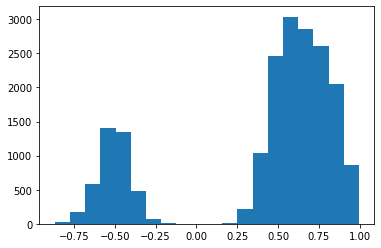

In [10]:
# Draw Histogram
plt.hist(ncc_pct_list, 20)
plt.show()

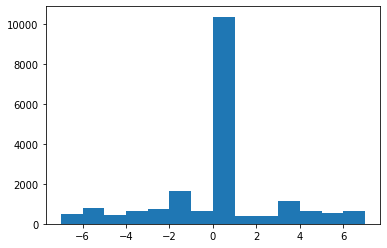

In [11]:
# Draw Histogram
plt.hist(lag_pct_list, 14)
plt.show()

In [13]:
ncc_pct_list = []
lag_pct_list = []
company_values = {}
lag = 7
scale_columns = ['volume', 'price', 'ratio']


filepath= DATA_DIR + "025870.csv"
df = pd.read_csv(filepath, index_col=0)
df[scale_columns] -= df[scale_columns].min()
df[scale_columns] /= df[scale_columns].max()
df = df.dropna()

peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
top_peaks = df.iloc[peaks,:]
top_peaks = top_peaks.nlargest(20, 'ratio')
print(top_peaks)


top_timeframes = {}
timeframes_list = []
# Create timeframe for each peak
for idx, row in top_peaks.iterrows():
    # print(row)
    start = idx-lag 
    end = idx+lag
    if start < 0 or end > len(df.index):
        continue
    # print("Start: ", start, "End: ", end)
    timeframe = df[start:end]
    top_timeframes[row['period']] = timeframe
    timeframes_list.append(timeframe)

print(timeframes_list[0])

          period     price    volume     ratio
1362  2019-09-24  1.000000  0.741181  1.000000
1209  2019-04-24  0.179228  1.000000  0.260548
902   2018-06-21  0.380515  0.768819  0.256065
342   2016-12-08  0.471507  0.452843  0.229456
270   2016-09-27  0.415441  0.321392  0.177019
1326  2019-08-19  0.149816  0.312908  0.161366
1313  2019-08-06  0.088235  0.364954  0.130630
1197  2019-04-12  0.068934  0.487286  0.102526
381   2017-01-16  0.359375  0.247132  0.087656
353   2016-12-19  0.409007  0.093584  0.082604
90    2016-03-31  0.337316  0.083916  0.070153
585   2017-08-08  0.220588  0.334750  0.067236
314   2016-11-10  0.272978  0.028725  0.063963
920   2018-07-09  0.186581  0.236450  0.063323
327   2016-11-23  0.286765  0.109534  0.061615
570   2017-07-24  0.255515  0.150548  0.056564
822   2018-04-02  0.157169  0.140712  0.056564
986   2018-09-13  0.168199  0.143287  0.049662
1246  2019-05-31  0.082721  0.135633  0.049164
403   2017-02-07  0.354779  0.043136  0.047172
          per

19


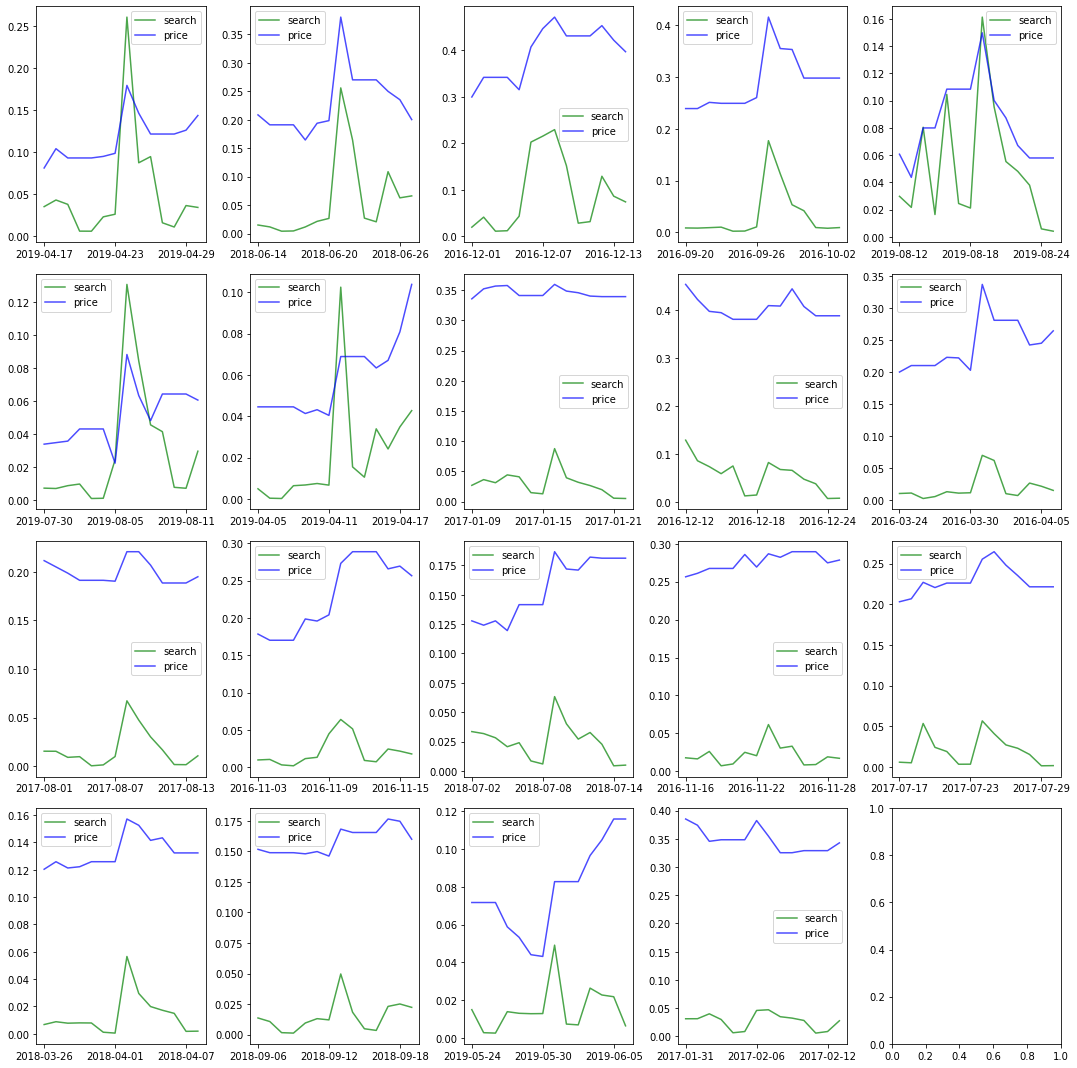

In [14]:
fig, ax = plt.subplots(4,5, figsize=(15,15))
fig.tight_layout()
length = len(timeframes_list)
print(length)
for idx, t in enumerate(timeframes_list):
    dates = t['period'].values
    ratio = t['ratio'].values
    price = t['price'].values
    row = int(idx/5)
    col = int(idx%5)
    
    ax[row, col].plot(dates, ratio, label="search", color='green', alpha=0.7)
    ax[row, col].plot(dates, price, label="price", color='blue', alpha=0.7)
    ax[row, col].set_xticks(dates[::6])
    ax[row, col].set_xticklabels(dates[::6], rotation=0)
    ax[row, col].legend()